<a href="https://colab.research.google.com/github/ephema/MEVBoost-Analysis/blob/main/%5Bephema%5D_MEV_Boost_Multi_Slot_MEV_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Block MEV Analysis

by [Pascal Stichler](https://x.com/pascalstichler) from [ephema Labs](https://www.ephema.io/)

---

## The What

We analyzed MEV-Boost payment data since the merge on September 15, 2022 until May 2024 (roughly 5 million data points) to identify patterns of multi-block MEV and correlation between validators and builders. We looked into sequences of a builder proposing blocks for multiple slots in a row as well as sequences where the same validator and builder where producting the blocks. Additionally, we looked into the MEV-Boost payments to identify patterns in how multi-slot sequences are valued. Further, volatility data has been included as well to cross-check effects of high volatility.

## The Why

Multi-block maximal extractable value (MEV) occurs when one party controls more than one consecutive block. It was first introduced by ([Babel et al., 2021](https://arxiv.org/abs/2109.04347)) as k-MEV and further elaborated by ([Mackinga et al., 2022](https://eprint.iacr.org/2022/445.pdf)). It is commonly assumed that controlling multiple slots in a sequence allows to capture significantly more MEV than controlling them individually. This derives from the fact that MEV accrues exponentially over time (e.g. as most recently presented by Jonah at Modular Summit '24 in Brussels ([Link](https://docs.google.com/presentation/d/1I7_Q9hheJHKteXLJiMSKb6bP34wxbZFgWV5O36KhiXE/edit#slide=id.g2ebba212d3a_0_122))). The most discussed strategies include TWAP oracle attacks on DEXes or producing forced liquidations by price manipulation and holding back orders.

After the merge ([Jensen et al., 2023](https://arxiv.org/pdf/2303.04430)) have looked into the first four month of data on multi-block MEV and summarized it as *"preliminary and non-conclusive results, [however] indicating [that] builders employ super-linear bidding strategies to secure consecutive block space"*.

With the recent Attester-Propose-Separation (ATS) and preconfirmation discussions multi-block MEV has become more of a pressing issue again as it might be prohibitive for some of the proposed designs. (For a more in-depth overview of recently proposed mechanism designs, we have created an overview [here](https://miro.com/app/board/uXjVK07aBCU=/?share_link_id=945029470742)). Hence, we decided to look into more comprehensive data covering almost 2 years time to identify novel patterns.


## The How

This analysis is done based on MEV boost data from the merge until mid May 2024. It is analyzed how MEB boost payment values change and how they interplay with the respective builders and validators.

The analysis is divided into first the data pre-processing and import and secondly the main data analysis. The individual chapters can be found in the Table of contents. The processed data is exported in section 1.4. and can be imported in section 1.5. directly to avoid always running time intense pre-processing steps. Note, that to directly import the data setion 1.1.1. & 1.5. (Import) need to be run to then start with Chapter 2.

The data necessary to run the analysis can be found in [this folder](https://drive.google.com/open?id=1TBK27OS7EfL4zyWtsDGCKPEJirvUC2W7&usp=drive_fs) and consists of the following files:

*   eth_data: Slots since Merge with additional MEV-Boost and validator info until 2023-10-18 (file name: openethdata_eth_data.parquet.gzip, ca. 200 MB, provided by Toni Wahrstätter)
*   pubkey_mapping:	Validator public keys mapped to known entities such as Lido, Kraken ect. (incl. Lido Node Operators) (file name: openethdata_validator_data.parquet.gzip, ca. 30 MB, provided by Toni Wahrstätter)
*   newer_eth_data: (file name: new_mev_boost_data.csv, ca. 150 MB, provided by Toni Wahrstätter)
*   Basefees: Ethereum basefees since the merge (file name: basefees.csv, ca. 90 MB, provided by Barnabé Monnot)

* (optional) MEV_boost_data_clean: Pre-processed and merged MEV boost data to work with that can be imported in section 1.5. (file name: mev_boost_data_clean.pkl, ca. 500 MB)

To import the data please adjust the file path in section 1.1.2. accordingly.

---



*Big thanks go to Toni Wahrstätter for providing the data and Barnabé Monnot for nudging the research in the first place and continuous valuable feedback as well as providing volatility data.*

# 1. Data Pre-Processing & Exploratory Insights

Here the data import and data pre-processing is happening. If you are just here for the results you can savely skip this section. Some of the steps might be time-consuming depending on the compute resources available. The processed data is also stored and provided and can be imported in section 1.5.. Only the library imports and Google Drive Mounting in section 1.1.1. have to be run.

Note that the names validator and proposer are used interchangeably in this analysis.

## 1.1. Data Import


### 1.1.1. Import Libraries and Mount Google Drive

In [ ]:
## Import Script for Libraries - Script to convert the file into CSV and load the parquet file
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import chi2_contingency
import seaborn as sns
import random
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.tsa.stattools import adfuller
import time
from collections import defaultdict

In [ ]:
from google.colab import drive
from google.colab import userdata
import secrets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1.2. Data Import of raw data

In [ ]:
## [Data Import & potential storing]

# Base directory for MEVBoost Analysis
base_directory = userdata.get('secret_base_directory')

# Parquet Files: Original Ethereum and Validator Data (adjust file path to your setup)
parquet_eth_data = base_directory + 'Data/InputData/openethdata_eth_data.parquet.gzip'
parquet_validator_data = base_directory + 'Data/InputData/openethdata_validator_data.parquet.gzip'

# CSV Files: New MEV Boost Data and Base Fees
csv_new_mev_boost_data = base_directory + 'Data/InputData/new_mev_boost_data.csv'
csv_base_fees = base_directory + 'Data/InputData/basefees.csv'

# Output File Paths
csv_output_mevboost = base_directory + 'Data/OutputData/MEVBoost_CSV.csv'
csv_output_mapping = base_directory + 'Data/OutputData/MEVBoost_Mapping_CSV.csv'

# Reading the Parquet file
older_mev_boost_data = pd.read_parquet(parquet_eth_data)
mev_mapping_data = pd.read_parquet(parquet_validator_data)

# Read the new data from Toni
newer_mev_boost_data = pd.read_csv(csv_new_mev_boost_data)

# Reading the Volatility Data from Barnabe
basefee_data = pd.read_csv(csv_base_fees)

# Ensuring right formatting & sorting
older_mev_boost_data['date'] = pd.to_datetime(older_mev_boost_data['date'])
older_mev_boost_data = older_mev_boost_data.sort_values(by='date')
newer_mev_boost_data['date'] = pd.to_datetime(newer_mev_boost_data['date'])
newer_mev_boost_data = newer_mev_boost_data.sort_values(by='date')
newer_mev_boost_data = newer_mev_boost_data.rename(columns={'value': 'mevboost_value'})
# Filtering out values beyond slot 9,065,606 as they are too new and don't contain builder & mevboost_value information anymore
newer_mev_boost_data = newer_mev_boost_data[newer_mev_boost_data['slot'] < 9065606]

# Create a DataFrame with the merged data
all_mev_boost_data = pd.concat([older_mev_boost_data, newer_mev_boost_data], ignore_index=True)

#Making all date fields tz-aware (UTC) for compatibilitiy
all_mev_boost_data['date'] = pd.to_datetime(all_mev_boost_data['date'], utc=True)
## Saving the DataFrame as a CSV file // file 1.2GB as csv so not saving it for now
# all_mev_boost_data.to_csv(csv_file_path, index=False)
# mev_mapping_data.to_csv(csv_file_path_mapping, index=False)

# print(f"File converted and saved as {csv_file_path}")

## 1.2. [Decision Gate] Data Selection

Please select which data source you want to use for the analysis. The other data sources should be commented out. The options are:
1. All Data: from 2022-09-15 (Slot 4700013, the merge) until 2024-05-13 (Slot 9065605)
2. Older Data: from 2022-09-15 (Slot 4700013) until 2023-10-18 (Slot 7563961)
3. Newer Data: from 2023-10-18 (Slot 7563962) until 2024-05-13 (Slot 9065605)

*Please note that the newer data has fewer data fields and misses data on `relay`, `builder_pubkey` & `proposer_pubkey`*

In [ ]:
## [Decision Gate]
## Select which data Set to use for the analysis

# 1. All Data: from 2022-09-15 (Slot 4700013, the merge) until 2024-05-13 (Slot 9065605)
mev_boost_data = all_mev_boost_data.copy()

## 2. Older Data
#mev_boost_data = older_mev_boost_data

## 3. Newer Data
#newer_mev_boost_data['relay'] = [None] * len(newer_mev_boost_data)
#newer_mev_boost_data['builder_pubkey'] = [None] * len(newer_mev_boost_data)
#newer_mev_boost_data['proposer_pubkey'] = [None] * len(newer_mev_boost_data)
#mev_boost_data = newer_mev_boost_data

## 1.3. Exploratory Data Analysis

In [ ]:
## [Exploratory Data Analysis] No data transformation

num_rows = len(mev_boost_data)
num_rows_basefee = len(basefee_data)
non_empty_count = mev_boost_data[mev_boost_data['mevboost_value'].notna() & (mev_boost_data['mevboost_value'] != '')].shape[0]
non_empty_count_builder = mev_boost_data[mev_boost_data['builder_pubkey'].notna() & (mev_boost_data['builder_pubkey'] != '')].shape[0]
non_empty_count_builder_name = mev_boost_data[mev_boost_data['builder'].notna() & (mev_boost_data['builder'] != '')].shape[0]
non_empty_count_proposer = mev_boost_data[mev_boost_data['proposer_pubkey'].notna() & (mev_boost_data['proposer_pubkey'] != '')].shape[0]
non_empty_count_proposer_name = mev_boost_data[mev_boost_data['validator'].notna() & (mev_boost_data['validator'] != '')].shape[0]
percentage_non_empty_mev = non_empty_count / num_rows
num_unique_slots = mev_boost_data['slot'].nunique()
non_unique_slots = num_rows - num_unique_slots
num_unique_blocks = mev_boost_data['block_number'].nunique()
print(f"Number of non-empty entries in 'mevboost_value': {non_empty_count}")
print(f"Number of Unique Slots: {num_unique_slots}")
print(f"Number of Non-Unique Slots: {non_unique_slots}")
print(f"Number of Unique Blocks': {num_unique_blocks}")
print(f"Number of non-empty entries in 'builder_pubkey': {non_empty_count_builder}")
print(f"Number of non-empty entries in 'builder': {non_empty_count_builder_name}")
print(f"Number of non-empty entries in 'proposer_pubkey': {non_empty_count_proposer}")
print(f"Number of non-empty entries in 'validator': {non_empty_count_proposer_name}")
print(f"Percentage non-empty MEV Values: {percentage_non_empty_mev}")
print(f"Number of entries: {num_rows}")
print(f"Number of entries with Base Fee: {num_rows_basefee}")

Number of non-empty entries in 'mevboost_value': 4535602
Number of Unique Slots: 4365300
Number of Non-Unique Slots: 743877
Number of Unique Blocks': 4323557
Number of non-empty entries in 'builder_pubkey': 3149325
Number of non-empty entries in 'builder': 4535602
Number of non-empty entries in 'proposer_pubkey': 3583146
Number of non-empty entries in 'validator': 5109128
Percentage non-empty MEV Values: 0.8877363223078786
Number of entries: 5109177
Number of entries with Base Fee: 4137911


Exploratory data analysis shows that there are around 700k non-unique slots in the data that need to be cleaned. Further, there are a few N/A values in different columns that need to be cleaned. This will be done in the next steps.

## 1.4. Data Cleaning & Further Pre-processing
Starting from here several data cleaning steps need to be done.
All steps are documented and need to be run before the analysis.

In [ ]:
## [Data Cleaning] Time intense data cleaning of duplicate entries (for certain entries multiple rows with the same data only different relays are in the dataset; for other slots multiple entries with different validators)
# Information will be collapsed into one entry and relay information will be stored as a nested list

start_time = time.time()
# Group by unique slot # values (collapse all others into lists)
mev_boost_data_collapsed = mev_boost_data.groupby('slot').agg(list).reset_index()

# Sort data chronologically
mev_boost_data_collapsed = mev_boost_data_collapsed.sort_values(by='date')
end_time = time.time()
print(f"Time taken to collapse data: {(end_time - start_time)/60} minutes")

Time taken to collapse data: 723.0370359420776 seconds


In [ ]:
## [Data Processing] Unnest the data for easier handling later and reduce duplicate values in lists. Note, that 0 values are excluded.

def unnest_or_condense(x):

    if not isinstance(x, list):
        return x  # Return the input as-is if it's not a list

    # Find the first non-None, non-empty, and non-'0.0' item in the list for comparison
    comparison_base = next((item for item in x if not pd.isna(item) and item not in ['', '0.0',0.0]), None)

    # If no valid comparison base found, return None or keep as list based on your preference
    if comparison_base is None:
        return None

    # Check if all non-None, non-empty, and non-'0.0' items in the list are the same as the comparison base
    if all(pd.isna(elem) or elem == comparison_base or elem in ['', '0',0.0] for elem in x):
        return comparison_base  # Return the comparison base if condition is met

    # Filter out None, '', '0.0' from the list for the final return
    filtered_x = [elem for elem in x if not pd.isna(elem) and elem not in ['', '0',0.0]]
    return filtered_x if filtered_x else None  # Return filtered list, or None if it becomes empty


# Specified columns to unnest or condense
columns_to_process = ['date','block_number', 'builder_pubkey','proposer_pubkey','mevboost_value','builder','validator']

mev_boost_data_clean = mev_boost_data_collapsed

for col in columns_to_process:
    mev_boost_data_clean[col] = mev_boost_data_clean[col].apply(unnest_or_condense)

In [ ]:
# Adding the Epoch information to the DF

mev_boost_data_clean['epoch'] = (mev_boost_data_clean['slot'] // 32).astype(int)

In [ ]:
# [DATA Sanity] Check to see how many duplicate values exist in each column.

columns_to_check = ['date','block_number',
                    'relay',
                    'builder_pubkey',
                    'proposer_pubkey','mevboost_value','builder','validator']  # List of column names to check, specific columsn can be commented out if not needed

pd.set_option('display.max_colwidth', None)

for col in columns_to_check:
    rows_with_lists = mev_boost_data_clean[mev_boost_data_clean[col].apply(lambda x: isinstance(x, list))]
    count_rows_with_lists = mev_boost_data_clean[col].apply(lambda x: isinstance(x, list)).sum()

    if not rows_with_lists.empty:
        #print(f"Rows with lists in '{col}':")
        print(f"Rows with lists in '{col}': {count_rows_with_lists}")
        #print(rows_with_lists)
    else:
        print(f"No lists found in '{col}'.")

No lists found in 'date'.
No lists found in 'block_number'.
Rows with lists in 'relay': 4365300
Rows with lists in 'builder_pubkey': 17958
No lists found in 'proposer_pubkey'.
Rows with lists in 'mevboost_value': 18
Rows with lists in 'builder': 20
Rows with lists in 'validator': 24319


It can be observed that for relays there are a lot of slots listing more than one relay. As relays are not scope of this analysis this can be ingnored. Further, validators and builder_pubkey has a few cases of multi-entries, which will be tackled in the following cells.

In [ ]:
## [Data Pre-Processing] - Based on the data analysis only very few incidents exist for duplicate values in mevboost_value & builder (<20)
# Hence they will be reduced for easier data handeling

# Function to calculate the average MEV-Boost value
def average_mev_boost(x):
    # Check if the input is a list
    if isinstance(x, list):
        # Convert all elements to numbers, ignoring NaNs
        numeric_values = pd.to_numeric(x, errors='coerce')
        # Calculate and return the average, ignoring NaNs
        return np.nanmean(numeric_values)
    # Return the input as is if it's not a list
    return x

# For MEV-Boost payments we will take the average payment and ensure the data is in numeric format
mev_boost_data_clean['mevboost_value'] = mev_boost_data_clean['mevboost_value'].apply(average_mev_boost)
mev_boost_data_clean['mevboost_value'] = pd.to_numeric(mev_boost_data_clean['mevboost_value'], errors='coerce')

# For the Builder Column values are set manually for blocks with duplicates based on information found on Etherscan
# Block #17034938 https://etherscan.io/block/17034938 - manta-builder
# Block #17035147 https://etherscan.io/block/17035147 - rsync-builder.xyz
# Block #17035222 https://etherscan.io/block/17035222 - manta-builder
# Block #17035228 https://etherscan.io/block/17035228 - manta-builder
# Block #17363100 https://etherscan.io/block/17363100 - aequitas et integritas
# Block #17655322 https://etherscan.io/block/17655322 - aequitas et integritas

# Manually set the builder values for specific blocks
block_builder_mapping = {
    17034938: 'manta-builder',
    17035147: 'rsync-builder.xyz',
    17035222: 'manta-builder',
    17035228: 'manta-builder',
    17363100: 'aequitas et integritas',
    17655322: 'aequitas et integritas'
}

for block_number, builder_name in block_builder_mapping.items():
    # Using .loc to find rows where the block_number matches and set the builder column
    mev_boost_data_clean.loc[mev_boost_data_clean['block_number'] == block_number, 'builder'] = builder_name

# Set all Flashbots blocks marked with [Flashbots SGX AND Flashbots TDX] to [Flashbots SGX] only
for index, row in mev_boost_data_clean.iterrows():
    if isinstance(row['builder'], list):
        if 'Flashbots SGX' in row['builder']:
            mev_boost_data_clean.at[index, 'builder'] = 'Flashbots SGX'

# For validators roughly 25k duplicate entries have been found, based on manual inspection mostly out of a conflict between celsius & blockdaemon
# For kiln sometimes more details are given (e.g. ["kiln" AND "bitpanda(kiln)"] for same slot). As "kiln" is the operator this is reduced to "kiln"
# For staking pools or staking operators the name of the operator will be used.
# Staking pools are treated as one entity, we are however aware that there are different operators running the nodes. However, we assume policy decisions are done at pool level.

count_else = 0
for index, row in mev_boost_data_clean.iterrows():
    if isinstance(row['validator'], list):
        if 'kiln' in row['validator']:
            mev_boost_data_clean.at[index, 'validator'] = 'kiln'
        elif 'celsius' in row['validator']:
            mev_boost_data_clean.at[index, 'validator'] = 'celsius'
        elif 'stakewise' in row['validator']:
            mev_boost_data_clean.at[index, 'validator'] = 'stakewise'
        elif 'everstake' in row['validator']:
            mev_boost_data_clean.at[index, 'validator'] = 'everstake'
        elif 'voiceversenft.eth' in row['validator']:
            mev_boost_data_clean.at[index, 'validator'] = 'voiceversenft.eth'
        elif 'flipside' in row['validator']:
            mev_boost_data_clean.at[index, 'validator'] = 'flipside'
        else:
            mev_boost_data_clean.at[index, 'validator'] = row['validator'][0] # Replace remaining ca. 120 duplicates with the first value as only long tail operators

# Sanity check print
print(mev_boost_data_clean.dtypes)

slot                             int64
date               datetime64[ns, UTC]
block_number                   float64
relay                           object
builder_pubkey                  object
proposer_pubkey                 object
mevboost_value                 float64
builder                         object
validator                       object
epoch                            int64
dtype: object


In [ ]:
## [Sanity Check] - No Data Transformation

print("Number of Data Entries:", len(mev_boost_data_clean))
print("Number of Empty Slots:")
na_counts_clean_data = mev_boost_data_clean.isna().sum()
print(na_counts_clean_data)

mev_boost_data_clean_sorted = mev_boost_data_clean.sort_values('slot')

# Calculate differences between consecutive slots
mev_boost_data_clean_sorted['slot_diff'] = mev_boost_data_clean_sorted['slot'].diff()

# Non-consecutive slots
non_consecutive_slots_mbdcs = mev_boost_data_clean_sorted[mev_boost_data_clean_sorted['slot_diff'] != 1]
non_consecutive_count_mbdcs = (mev_boost_data_clean_sorted['slot_diff'] != 1).sum()

print(f"Number of non-consecutive slots: {non_consecutive_count_mbdcs}")
print(f"Non-consecutive slots found at:")
print(non_consecutive_slots_mbdcs['slot'])

Number of Data Entries: 4365300
Number of Empty Slots:
slot                     0
date                     0
block_number         30625
relay                    0
builder_pubkey     1935514
proposer_pubkey    1501657
mevboost_value      573115
builder             573111
validator               13
epoch                    0
dtype: int64
Number of non-consecutive slots: 9
Non-consecutive slots found at:
0          4700013
1702084    6402112
1911929    6612045
1911930    6612047
1911940    6612058
1912023    6612207
1912035    6612327
2014044    6714349
2014045    6714351
Name: slot, dtype: int64


### 1.4.1. Data Cleaning and exploratory Analysis of Volatility Data

In [ ]:
# [Analysis & Data Transformation] Needs to be run to adjust volatility data

# Data Transformation
basefee_data = basefee_data.assign(base_fee_per_gas_in_gwei = basefee_data['base_fee_per_gas'] / 1000000000)

# Adjust MEV Boost Data to avoid transferring duplicates
reduced_set_mev_data = mev_boost_data_clean.sort_values(by='block_number').drop_duplicates('block_number')

# Merge Slot, epoch & Date info into basefee DF
basefee_data_merged = pd.merge(basefee_data, reduced_set_mev_data[['slot', 'block_number', 'epoch', 'date']], left_on='number', right_on='block_number', how='left')
basefee_data_merged = basefee_data_merged.drop(['block_number'], axis=1)
basefee_data_merged = basefee_data_merged.rename(columns={'number': 'block_number'})

# Descriptive Stats
descriptive_stats = basefee_data_merged['base_fee_per_gas_in_gwei'].describe()

print("Descriptive Statistics for the Base Fee")
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(descriptive_stats)

# Base Fee: Percentage Changes & Volatility Index

basefee_data_merged['percentage_change'] = basefee_data_merged['base_fee_per_gas_in_gwei'].pct_change() * 100
descriptive_stats_change_rate = basefee_data_merged['percentage_change'].describe(percentiles=[0.1, 0.9])

print("Descriptive Statistics for the Change Rate")
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(descriptive_stats_change_rate)
basefee_data_merged['high_vola_simple'] = (basefee_data_merged['percentage_change'] <= descriptive_stats_change_rate['10%']) | (basefee_data_merged['percentage_change'] >= descriptive_stats_change_rate['90%'])

## High Volatility after adj. Garman-Klass volatility (adjusted to fit epochs)
# https://arxiv.org/pdf/0807.3492

# Group by 'epoch' to calculate Open, High, Low, and Close
ohlcv = basefee_data_merged.groupby('epoch')['base_fee_per_gas_in_gwei'].agg(
        Open=lambda x: x.iloc[0],
        High='max',
        Low='min',
        Close=lambda x: x.iloc[-1]
    ).reset_index()

# Calculate squared logarithms of the ratios
ohlcv['log_hl'] = np.log(ohlcv['High'] / ohlcv['Low'])**2
ohlcv['log_co'] = np.log(ohlcv['Close'] / ohlcv['Open'])**2

# Adj. Garman-Klass volatility
ohlcv['volatility_gk'] = 0.5 * ohlcv['log_hl'] - (2 * np.log(2) - 1) * ohlcv['log_co']
descriptive_stats_gk = ohlcv['volatility_gk'].describe(percentiles=[0.2, 0.8])
ohlcv['high_vola_gk'] = ohlcv['volatility_gk'] >= descriptive_stats_gk['80%']

# Merge into basefee
basefee_data_merged = pd.merge(basefee_data_merged, ohlcv[['epoch', 'high_vola_gk']], on='epoch', how='left')

Descriptive Statistics for the Base Fee
count   4137911.00
mean         26.49
std          21.81
min           1.71
25%          13.61
50%          20.35
75%          32.53
max         813.23
Name: base_fee_per_gas_in_gwei, dtype: float64
Descriptive Statistics for the Change Rate
count   4137910.00
mean          0.12
std           4.98
min         -12.50
10%          -4.86
50%          -0.86
90%           7.71
max          12.50
Name: percentage_change, dtype: float64


In [ ]:
# Merge Base Fee with MEV Boost Data & Adjust Data Types

mev_boost_data_clean_merged = pd.merge(
    mev_boost_data_clean,
    basefee_data_merged[['base_fee_per_gas_in_gwei','percentage_change','high_vola_simple','high_vola_gk', 'block_number']],
    on='block_number',
    how='left')
#mev_boost_data_clean['block_number'] = mev_boost_data_clean['block_number'].astype('int64')
mev_boost_data_clean_merged['high_vola_simple'] = mev_boost_data_clean_merged['high_vola_simple'].astype('bool')
mev_boost_data_clean_merged['high_vola_gk'] = mev_boost_data_clean_merged['high_vola_gk'].astype('bool')

mev_boost_data_clean = mev_boost_data_clean_merged.copy()
mev_boost_data_clean.sort_values(by='date', inplace=True)

## From here onward mev_boost_data_clean should not be corrupted anymore

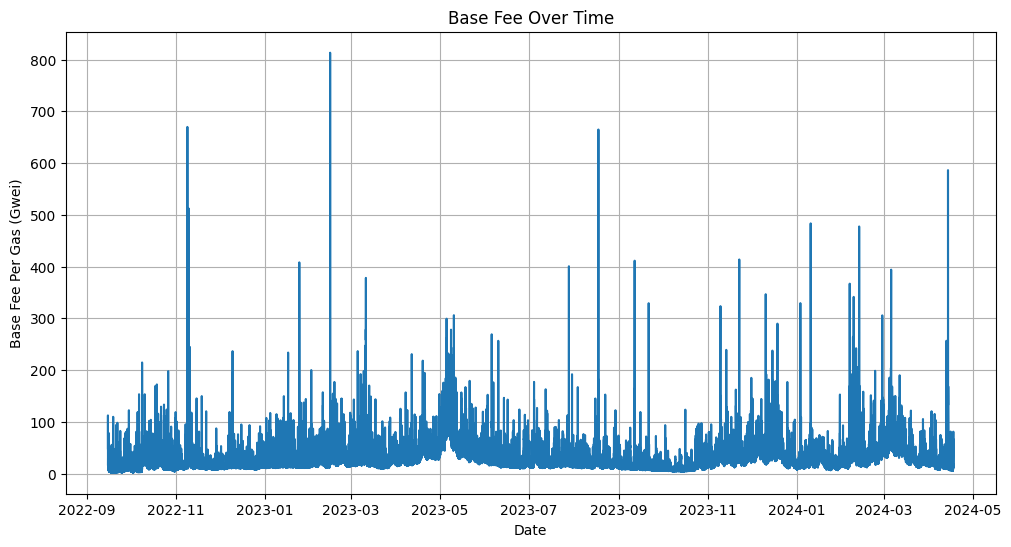

In [ ]:
# Optional: Chart with Base Fee

# Handle missing dates
basefee_data_merged['date'] = pd.to_datetime(basefee_data_merged['date'], errors='coerce') # Convert to datetime, replacing invalid dates with NaT
basefee_data_merged.dropna(subset=['date'], inplace=True) # Remove rows with NaT in the 'date' column

# Sort by date
basefee_data_merged.sort_values(by='date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(basefee_data_merged['date'], basefee_data_merged['base_fee_per_gas_in_gwei'])
plt.xlabel('Date')
plt.ylabel('Base Fee Per Gas (Gwei)')
plt.title('Base Fee Over Time')
plt.grid(True)
plt.show()

Charting the basefee we can see high volatility in the data with the highest value being above 800 Gwei in slot 5798080 on February 14th, 2023.

## 1.5. Export & Import of Processed Data

In [ ]:
# Export MEV Boost Data Clean

pkl_file_path_clean_data = base_directory + 'Data/WorkingData/mev_boost_data_clean.pkl'

mev_boost_data_clean.to_pickle(pkl_file_path_clean_data)

In [ ]:
# Import MEV Boost Data Clean
base_directory = userdata.get('secret_base_directory')
pkl_file_path_clean_data = base_directory + 'Data/WorkingData/mev_boost_data_clean.pkl'
mev_boost_data_clean = pd.read_pickle(pkl_file_path_clean_data)
mev_boost_data_clean.dtypes

,0
slot,int64
date,"datetime64[ns, UTC]"
block_number,float64
relay,object
builder_pubkey,object
proposer_pubkey,object
mevboost_value,float64
builder,object
validator,object
epoch,int64


# 2. Data Analysis
The data is now analyzed with regard to different aspects.
1.   Descriptive Statistics
2.   MEV Boost Payment (Auto-)Correlation Analysis
3. [Excursus] Builder & Proposer Correlation
4. Multi-Slot Analysis
5. MEV Boost Payments Analysis for Multi-Slot Sequences

## 2.1. Descriptive Statistics
For a better understanding of the data general descriptive Statistics on the MEV Boost data are explored and shown.

In [ ]:
## [Data Analysis] - No Transformation - Number of Unique Builders and Validators

num_unique_builder = mev_boost_data_clean['builder'].nunique()
num_unique_validator = mev_boost_data_clean['validator'].nunique()
print(f"Number of Unique Builders in the Data Set '{num_unique_builder}'.")
print(f"Number of Unique Validators in the Data Set '{num_unique_validator}'.")

Number of Unique Builders in the Data Set '165'.
Number of Unique Validators in the Data Set '299927'.


In [ ]:
# [Analysis] Descriptive Statistics

mev_boost_data_clean.sort_values(by='date', inplace=True)
mevboost_value = mev_boost_data_clean['mevboost_value']
mevboost_value_in_eth = mevboost_value / (10**18)

print("Descriptive Statistics for MEV Boost Payments")
print("Empty Values in mevboost_value:", mev_boost_data_clean['mevboost_value'].isna().sum())
print("Mean:", mevboost_value_in_eth.mean())
print("Median:", mevboost_value_in_eth.median())
print("Mode:", mevboost_value_in_eth.mode().tolist())  # Convert to list to handle potentially multiple modes
print("Standard Deviation:", mevboost_value_in_eth.std())
print("Minimum:", mevboost_value_in_eth.min())
print("Maximum:", mevboost_value_in_eth.max())
print("Range:", mevboost_value_in_eth.max() - mevboost_value_in_eth.min())
print("25th, 50th, and 75th Percentiles:", mevboost_value_in_eth.quantile([0.25, 0.5, 0.75]).tolist())
print("Skewness:", mevboost_value_in_eth.skew())
print("Kurtosis:", mevboost_value_in_eth.kurtosis())

Descriptive Statistics for MEV Boost Payments
Empty Values in mevboost_value: 573115
Mean: 0.12459310301303542
Median: 0.051058551259333194
Mode: [0.015]
Standard Deviation: 1.4463900400077039
Minimum: 1.9984464565687e-05
Maximum: 691.9631922654178
Range: 691.9631722809532
25th, 50th, and 75th Percentiles: [0.030445352527477824, 0.051058551259333194, 0.09579270583262259]
Skewness: 256.6530927910782
Kurtosis: 89864.31205715449


Based on this we can observe that the data is heavily skewed towards low values with outliers among higher values. This is expected as MEV is known to be spiky and can rapidly rise during volatile times where often single transactions give the opportunity for large MEV capture.

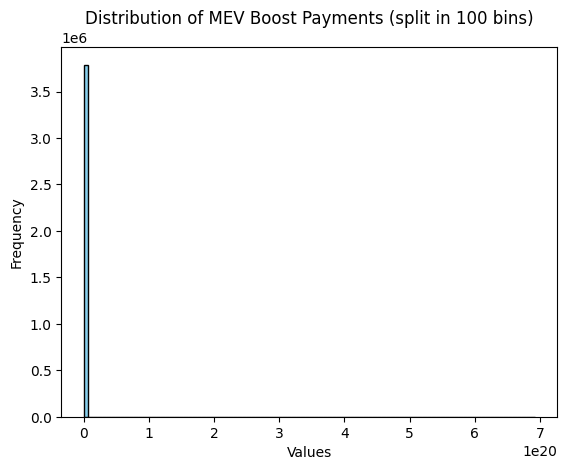

In [ ]:
# [Visualization]
# Plot histogram
plt.hist(mevboost_value, bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of MEV Boost Payments (split in 100 bins)')

# Show plot
plt.savefig(base_directory + 'Graphics/Distribution of MEV Boost Payments.png')
plt.show()

We can observe that the vast majority of the data MEV-Boost payments is in the first "bin" and close to 0. The payment values are exponentially distributed.

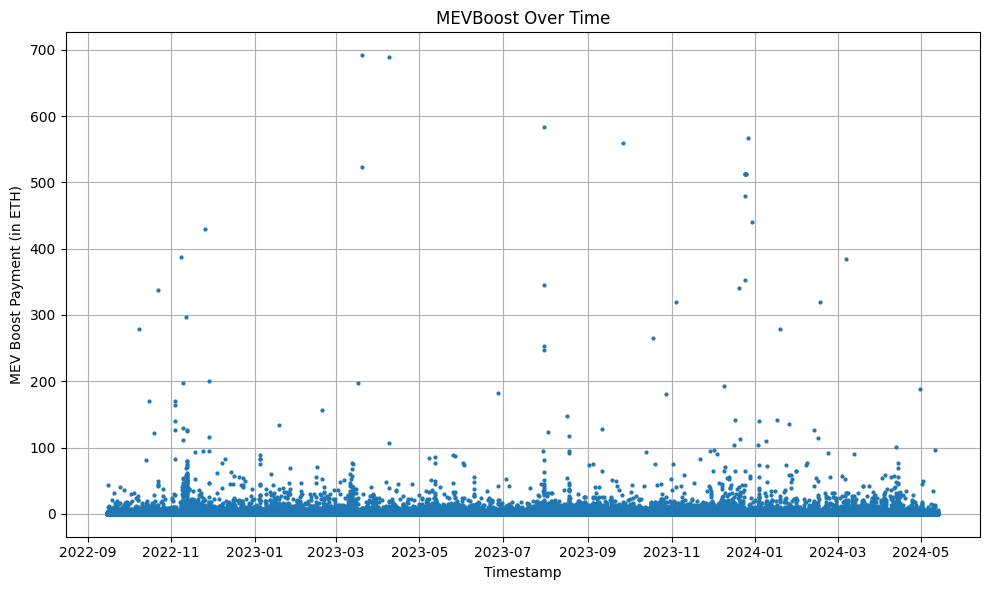

In [ ]:
# [Visualization] MEV Over Time
mev_boost_data_sorted = mev_boost_data_clean.sort_values(by='date')

# Plot the data over time
plt.figure(figsize=(10, 6))
plt.plot(mev_boost_data_sorted['date'], mev_boost_data_sorted['mevboost_value']/10**18, marker='o', markersize=2, linestyle='')
plt.xlabel('Timestamp')
plt.ylabel('MEV Boost Payment (in ETH)')
plt.title('MEVBoost Over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig(base_directory + 'Graphics/MEVBoost Payments over Time.png')
plt.show()

## 2.2. MEV Boost Payment (Auto-)Correlation Analysis
In the next step potential auto-correlation in the data is tested to evaluate if historical MEV data allows to forecast future MEV. This can also be an indication of high- and low-MEV periods.

Therefore we conduct the following analyses:


1.   Correlation with up to 32 slots offset on different correlation measurements: Pearson Correlation Coefficient, Spearman's Rank Correlation Coefficient and Kendall's Rank Correlation Coefficient. As a cross-check it will be done for all data as well as for only the top 50 % of MEV boost values.
2.   Classical auto-correlation measurement with up to 10 slots offset.



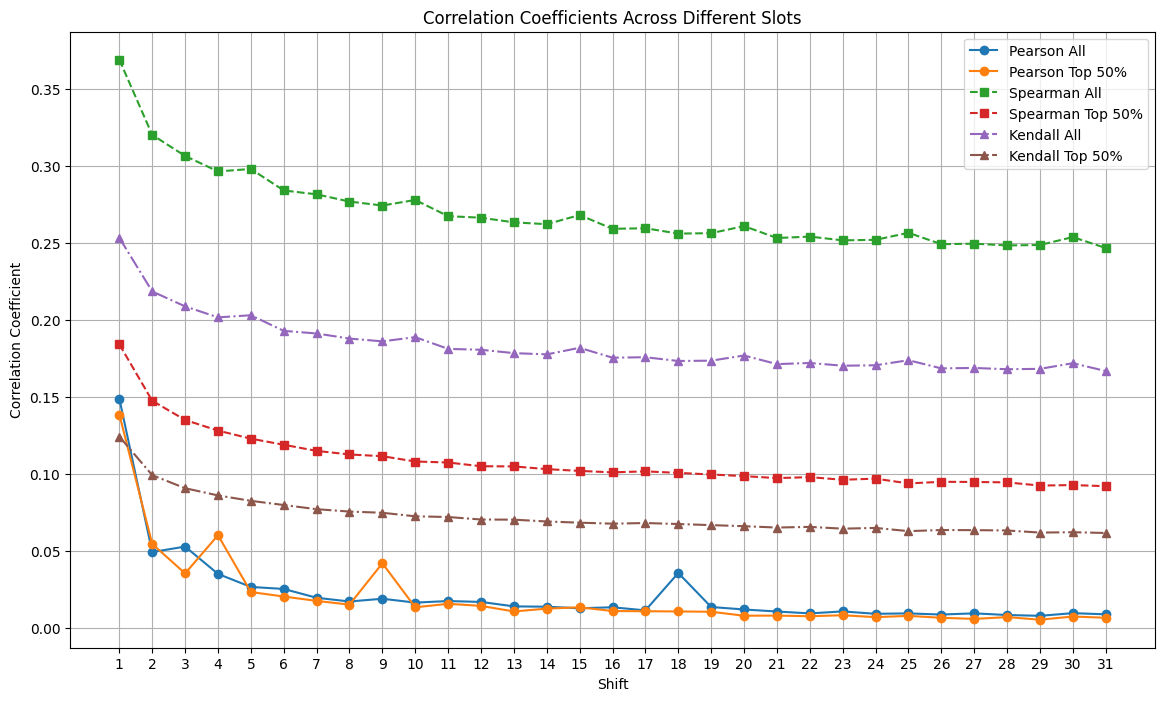

In [ ]:
## [Analysis & Visualization] calculating the correlation between consecutive values to understand if MEV is seasonal

# sorting the data first
mev_boost_data_sorted = mev_boost_data_clean.sort_values(by='date')
mevboost_value = mev_boost_data_sorted['mevboost_value']

# Convert decimal.Decimal values to float
mevboost_value = mevboost_value.astype(float)

# Sanity Check: Only use top 50% data
cutoff = mevboost_value.quantile(0.5)
top_50_p_values = mevboost_value[mevboost_value > cutoff]

# Optimized way to calculate correlations for various shifts, including the top 50%
shifts = range(1, 32)  # Considering shifts for one epoch
results = []  # To store the results for each shift

# Loop through each shift
for shift in shifts:
    shifted_data = mevboost_value.shift(shift)
    shifted_data_50 = top_50_p_values.shift(shift)

    # For all data
    concatenated_data = pd.concat([mevboost_value, shifted_data], axis=1).dropna()
    pearson_corr = pearsonr(concatenated_data.iloc[:, 0], concatenated_data.iloc[:, 1])[0]
    spearman_corr = spearmanr(concatenated_data.iloc[:, 0], concatenated_data.iloc[:, 1])[0]
    kendall_corr = kendalltau(concatenated_data.iloc[:, 0], concatenated_data.iloc[:, 1])[0]

    # For top 50% data
    concatenated_data_50 = pd.concat([top_50_p_values, shifted_data_50], axis=1).dropna()
    pearson_corr_50 = pearsonr(concatenated_data_50.iloc[:, 0], concatenated_data_50.iloc[:, 1])[0]
    spearman_corr_50 = spearmanr(concatenated_data_50.iloc[:, 0], concatenated_data_50.iloc[:, 1])[0]
    kendall_corr_50 = kendalltau(concatenated_data_50.iloc[:, 0], concatenated_data_50.iloc[:, 1])[0]

    # Store the results
    results.append({
        'Shift': shift,
        'Pearson All': pearson_corr,
        'Pearson Top 50%': pearson_corr_50,
        'Spearman All': spearman_corr,
        'Spearman Top 50%': spearman_corr_50,
        'Kendall All': kendall_corr,
        'Kendall Top 50%': kendall_corr_50,
    })

# Convert results to a DataFrame for a neat table
results_df = pd.DataFrame(results)
results_df.set_index('Shift', inplace=True)

## Display the results table
# print(results_df)

# Assuming `results_df` is your DataFrame containing the correlation results
shifts = results_df.index.values

# Plotting
plt.figure(figsize=(14, 8))

# Pearson
plt.plot(shifts, results_df['Pearson All'], marker='o', linestyle='-', label='Pearson All')
plt.plot(shifts, results_df['Pearson Top 50%'], marker='o', linestyle='-', label='Pearson Top 50%')

# Spearman
plt.plot(shifts, results_df['Spearman All'], marker='s', linestyle='--', label='Spearman All')
plt.plot(shifts, results_df['Spearman Top 50%'], marker='s', linestyle='--', label='Spearman Top 50%')

# Kendall
plt.plot(shifts, results_df['Kendall All'], marker='^', linestyle='-.', label='Kendall All')
plt.plot(shifts, results_df['Kendall Top 50%'], marker='^', linestyle='-.', label='Kendall Top 50%')

# Adding legend
plt.legend()

# Titles and labels
plt.title('Correlation Coefficients Across Different Slots')
plt.xlabel('Shift')
plt.ylabel('Correlation Coefficient')
plt.xticks(shifts)  # Ensure we have a tick for every shift value

# Display the plot
plt.grid(True)
plt.savefig(base_directory + 'Graphics/Correlation_Coefficients.png')
plt.show()


 Overall it can be observed that within the first few slots shift correlation strongly decreases until slot 2 to 3. Based on this we can conclude that not more than one to three slots in advance the MEV value can be reliably predicted based on historical data. It is important to note, that other data might allow for such forecasts such as pending transactions in the mempool or DEX trading volumes as a leading indicator for MEV opportunities. This could be further investigated, however given that MEV Boost bids only meaningfully increase in the last 2.5 seconds before the slot time, this does not seem to be the case.

Further interesting observations can be made. As expected the Spearman and Kendall correlation coefficients are significantly higher than the Pearson correlation underlining that the data is not following a normal distribution being skewed and having high outliers. Additionally, it is interesting to note that for the Pearson correlation coefficient the complete data set and the top 50 % quantile dataset behave similarly, which is not the case for the Spearman and Kendall coefficients. This might be an indicator that the rank ordering for the lower 50 % quantile can be more reliably predicted using historical data than the change in value. Further, we can observe spikes in the Pearson correlation coefficient for slots 4, 9 and 18. Given the low level overall, we attribute this currently to normal noise in the data.

All of this analysis shall be seen as exploratory and might need further cross validation.

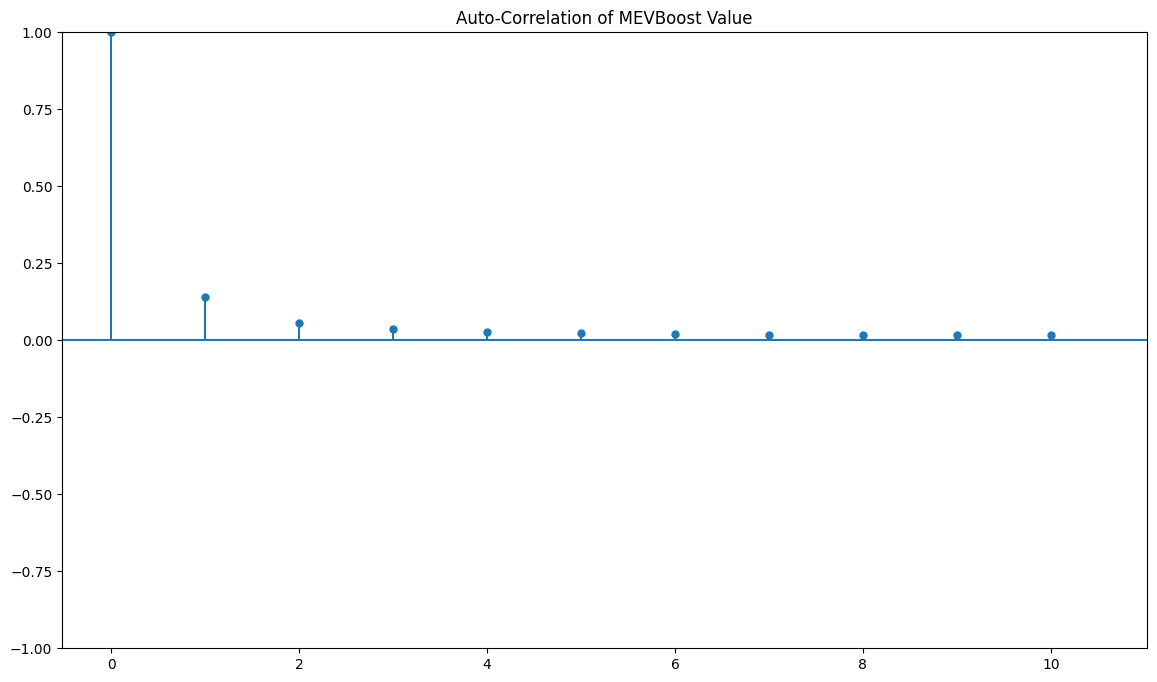

Time taken: 3111.9104800224304 seconds


In [ ]:
## [Visualization] Additionally auto-correlation is measured - time-intensive

# Dropping NA Values
mevboost_value = mev_boost_data_clean['mevboost_value'].dropna().astype(float)

start_time = time.time()
# Calculate and visualize the auto-correlation
fig, ax = plt.subplots(figsize=(14, 8))
plot_acf(mevboost_value, ax=ax, lags=10)  # Using 10 lags (using 32 lags to time-intensive and no further insights are expected)
end_time = time.time()

# Show the plot
plt.title('Auto-Correlation of MEVBoost Value')
plt.savefig(base_directory + 'Graphics/Auto-Correlation.png')  # Saves the plot as a PNG file
plt.show()
print("Time taken:", end_time - start_time, "seconds")

Further, we observe in the auto-correlation only a weak positive correlation. That sharply decreases after N+1. This confirms the finding that based on historical data only one to two slots can be somewhat predicated in advance.

In [ ]:
# Checking for stationarity with Augmented Dickey-Fuller (ADF) test

# Downsampling to suffice with hardware availabilities (only 51gb RAM). As long term trend is investigated, down-sampling is feasible.
downsample_rate = 10
mevboost_value = mev_boost_data_clean['mevboost_value'].dropna().astype(float)
downsampled_mev_boost_values = mevboost_value.iloc[::downsample_rate]
start_time = time.time()
adf_results = adfuller(downsampled_mev_boost_values)
end_time = time.time()

# Extracting and printing the results
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])
print('Critical Values:', adf_results[4])

# Interpretation
if adf_results[1] < 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")

print("Time taken:", end_time - start_time, "seconds")

ADF Statistic: -47.50592987047346
p-value: 0.0
Critical Values: {'1%': -3.4303672486087002, '5%': -2.861547623676665, '10%': -2.5667740578055387}
Reject the null hypothesis: The time series is stationary.
Time taken: 165.66687059402466 seconds


Using an Augmented Dickey-Fuller (ADF) test, it shows a very low ADF statistic and it can be confirmed that the data is stationary. This indicates that the properties of the data are constant over time and no seasonal effects or similar have to be taken into account.

### Summary on Auto-Correlation

Overall, we can conlcude that the correlation between sequential slots is weakly positive. This indicates that there is generally a trend of high and low MEV periods, as opposed for example the hypothesis that after a high-MEV slot a low-MEV slot follows because all MEV has been captured. However, the correlation is only on a very modest level which would make forecasting based on only historical MEV data difficult.

## 2.3. [Excursus] Builder & Proposer Correlation
As a short excursus to the main analysis, it is analyzed if there is a correlation between specific builders and proposers for block-building for slots. Therefore, a contingency table is created with the number of slots that a proposer was selected for a certain slot and a builder won the MEV boost auction. This is compared, with what would have been expected based on the market shares of the top builders and proposers with more than 1% market share for the time period. The difference on this is analyzed via Chi-Square test as well as visualized.

Further, the contingency table can be created for specific months to cross-check the results.

In [ ]:
## [Analysis] Excursus: Measuring correlation of Builder & Proposer

## Optional
# Use for specific year
mev_boost_data_clean_2024 = mev_boost_data_clean[(mev_boost_data_clean['date'].dt.year == 2024)]
# Use for specific month
mev_boost_data_clean_09_2023 = mev_boost_data_clean[
    (mev_boost_data_clean['date'].dt.year == 2023) & (mev_boost_data_clean['date'].dt.month == 9)]

## Select desired time period of data to generate contingency_table
contingency_table = pd.crosstab(mev_boost_data_clean['builder'], mev_boost_data_clean['validator'])
#contingency_table = pd.crosstab(mev_boost_data_clean_2024['builder'], mev_boost_data_clean_2024['validator'])
#contingency_table = pd.crosstab(mev_boost_data_clean_09_2023['builder'], mev_boost_data_clean_09_2023['validator'])

contigency_table_complete = contingency_table

total_slots = contingency_table.values.sum()

# Identify validators & builders with less than 1% of the total slots
validators_below_1pct = contingency_table.columns[contingency_table.sum(axis=0) < total_slots * 0.01]
builders_below_1pct = contingency_table.index[contingency_table.sum(axis=1) < total_slots * 0.01]

# Aggregate counts for validators and builders below 1% into "Other" categories
other_validator_counts = contingency_table[validators_below_1pct].sum(axis=1)
other_builder_counts = contingency_table.loc[builders_below_1pct].sum(axis=0)

# Aggregate counts for "Other" validators and builders
contingency_table['Other Validator'] = contingency_table[validators_below_1pct].sum(axis=1)
other_builder_counts = contingency_table.loc[builders_below_1pct].sum(axis=0)
contingency_table = contingency_table.drop(columns=validators_below_1pct)
contingency_table = contingency_table.drop(builders_below_1pct)

# Append "Other" builder counts as a new row
other_builder_counts['Other Validator'] = contingency_table['Other Validator'].sum()  # Including the sum for the "Other Validator" column
contingency_table.loc['Other Builder'] = other_builder_counts

# Ensure no NaN values
contingency_table.fillna(0, inplace=True)

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# print(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")


## Save the contingency table to a CSV file
# file_path_ct = base_directory + 'Contigency_table.csv'
#contingency_table.to_csv(file_path_ct, index=True)

Chi-Square Statistic: 1275667.5325795729, p-value: 0.0


Based on the data an extremely high Chi-Square value is observed. The null-hypothesis that the slot distribution for proposers and builders can be rejected. So we observe that there is a statistically significant relationship between both.
This could be due to several reasons. So, to get a deeper insight, the relationships are visualized.

In [ ]:
## [Visualization] Excursus 2: Observed vs. statistical occurence of Builder-Validator Cooperation
# Needs data from excursus 1
# Output is in text form, can be commented in

validator_slot_sum = contingency_table.sum(axis=0)
builder_slot_sum = contingency_table.sum(axis=1)
total_slots = contingency_table.values.sum()

# Calculate expected slots for each builder-validator combination
expected_slots = pd.DataFrame(index=contingency_table.index, columns=contingency_table.columns)
for validator in contingency_table.columns:
    for builder in contingency_table.index:
        expected_value = (builder_slot_sum[builder] * validator_slot_sum[validator]) / total_slots
        expected_slots.at[builder, validator] = round(expected_value)

# Calculate deviance between observed and expected slots
deviance = contingency_table - expected_slots

## Print the expected slots and the deviance to observe the differences (can be enabled)
#print("Expected Slots:")
#print(expected_slots)
#print("\nDeviance (Observed - Expected):")
#print(deviance)

## Relative Deviance calculated as well

# Ensure expected_slots is in the correct numeric type for operations
expected_slots = expected_slots.astype(float)

# Calculate relative deviance as a percentage
relative_deviance = ((contingency_table - expected_slots) / expected_slots) * 100

# Handle divisions by zero or where expected slots are zero by replacing NaN or infinite values with an appropriate marker
relative_deviance.replace([np.inf, -np.inf], np.nan, inplace=True)  # Option to replace infinite values with NaN
relative_deviance.fillna(0, inplace=True)  # Replacing NaNs with 0 or another placeholder if preferred

#print("Relative Deviance (%):")
#print(relative_deviance)

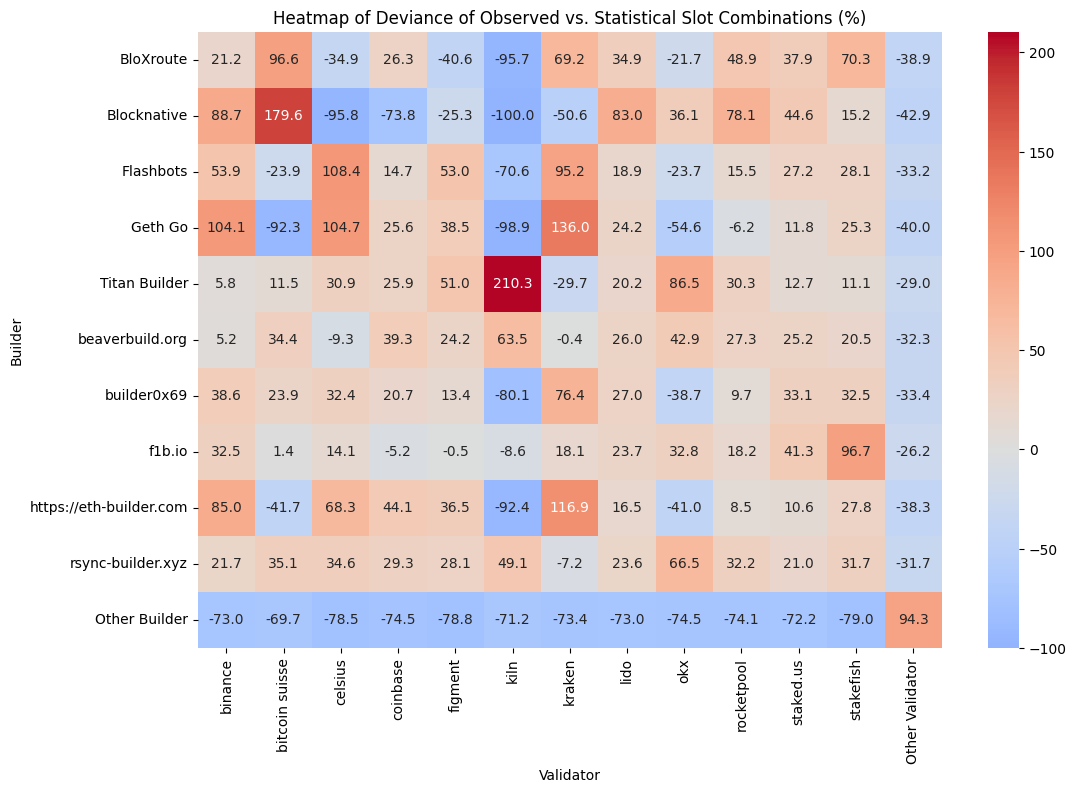

In [ ]:
# [Visualization] Plot Heatmap (Excursus 1 & 2 required to run before)
plt.figure(figsize=(12, 8))
sns.heatmap(relative_deviance, cmap='coolwarm', fmt=".1f", annot=True, center=0)
plt.title('Heatmap of Deviance of Observed vs. Statistical Slot Combinations (%)')
plt.xlabel('Validator')
plt.ylabel('Builder')
plt.show()

### Summary on Builder - Proposer Correlation

As seen by the Chi-Square value we can observe a statistical correlation between the proposer and builder for a specific slot. Random samples on specific months have also shown that this trend seems generally to be consistent also for single months time periods.

Mapping out the largest validators and builders (>1% market share) we can make several observations:


*   Long tail validators and builders (defined as having less than 1% market share), seem to have more slots with long-tail builders having 94% more observed slots together than statistically expected.
*   A few instances of higher concurrent slots can be observes such as: Titan Builder - Kiln, Blocknative - Bitcoin Suisse and Geth Go - Kraken.
*   Some builders such as Blocknative and the Geth Go client show uneven patterns.
*   Similarly some validators such as Kiln and Kraken show particularly uneven patterns.

Given that MEV Boost should be agnostic and the builder with the highest bid should be evenly distributed, hence these results are unexpected. Nevertheless, it cannot be said why this is happening and this could be an avenue for future research. Some practical reasons could be (correlated) fluctuating market shares of certain builders and validators. Further, geographical proximity (and hence lower latency) could be a factor, especially in more recent times when timing games became more prevalent.

## 2.4. Multi-Slot Analysis

In this section multi-slot sequences are investigated. It is first analyzed if multi-slot sequences occur more often than randomly expected. Further, it is than checked on an individual builder level, if they happen more often than statistically expected. Further, MEV boost payments for multi-slot sequences as well as payments per slot for longer sequences are investigated to understand if multi-slot sequences contain higher value.

### 2.4.1. Builder Marketshares

In [ ]:
## [Data Transformation & Analysis] Builder marketshare & Prepare Input for MC

# Count unique occurrences of each builder name
builder_counts = mev_boost_data_clean['builder'].value_counts()

# Extract the month and year for grouping
mev_boost_data_clean['year_month'] = mev_boost_data_clean['date'].dt.to_period('M')
mev_boost_data_clean['year_day'] = mev_boost_data_clean['date'].dt.to_period('D')

# Identify the top 10 builders based on the entire dataset
top_10_builders = builder_counts.head(10).index.tolist()

# Function to calculate market share
def calculate_market_share(df, top_10_builders):
    builder_counts = df['builder'].value_counts()
    total_builder_slots = builder_counts.sum()

    builder_counts_df = builder_counts.reset_index()
    builder_counts_df.columns = ['Builder', 'Count']
    builder_counts_df['Count'] = builder_counts_df['Count'].astype(int)
    builder_counts_df['Market Share (%)'] = (builder_counts_df['Count'] / total_builder_slots) * 100

    # Extract top 10 builders and calculate their market share
    top_10_builders_df = builder_counts_df[builder_counts_df['Builder'].isin(top_10_builders)].copy()
    top_10_builders_df = top_10_builders_df.set_index('Builder').reindex(top_10_builders).reset_index().fillna(0)
    top_10_builders_df['Count'] = top_10_builders_df['Count'].astype(int)


    # Calculate "Other" category by summing counts of all builders not in the top 10
    other_count = int(builder_counts_df[~builder_counts_df['Builder'].isin(top_10_builders)]['Count'].sum())
    other_market_share = (other_count / total_builder_slots) * 100
    other_row = pd.DataFrame(data={'Builder': ['Other Builders'], 'Count': [other_count], 'Market Share (%)': [other_market_share]})

    # Append "Other" row to the top 10 builders DataFrame
    top_10_builders_with_other = pd.concat([top_10_builders_df, other_row], ignore_index=True)
    return top_10_builders_with_other

# Calculate total market share
total_market_share = calculate_market_share(mev_boost_data_clean, top_10_builders)

# Apply the function monthly
monthly_market_share = mev_boost_data_clean.groupby('year_month').apply(lambda df: calculate_market_share(df, top_10_builders)).reset_index()
daily_market_share = mev_boost_data_clean.groupby('year_day').apply(lambda df: calculate_market_share(df, top_10_builders)).reset_index()

# Display the results
pd.set_option('display.max_rows', 128)
print("Total Market Share:\n", total_market_share)
# print("\nMonthly Market Share:\n", monthly_market_share)
pd.reset_option('display.max_rows')

<ipython-input-9-a3c5def29c81>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  mev_boost_data_clean['year_month'] = mev_boost_data_clean['date'].dt.to_period('M')
<ipython-input-9-a3c5def29c81>:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  mev_boost_data_clean['year_day'] = mev_boost_data_clean['date'].dt.to_period('D')


Total Market Share:
                     Builder    Count  Market Share (%)
0           beaverbuild.org  1032625         27.230315
1         rsync-builder.xyz   612404         16.149090
2                 Flashbots   540456         14.251821
3               builder0x69   487881         12.865419
4             Titan Builder   484706         12.781694
5                 BloXroute   173899          4.585716
6               Blocknative    73249          1.931576
7   https://eth-builder.com    52494          1.384266
8                    f1b.io    42505          1.120857
9                   Geth Go    39199          1.033677
10           Other Builders   252771          6.665570


### 2.4.2. Observed Multi-Slot Sequences

In [ ]:
## [Data Transformation] Observed Multi-Slot Frequency in Data Set (Code might be simplified)

mev_boost_consecutive = (
    mev_boost_data_clean.sort_values(by='date')
    .assign(builder_changed=lambda x: x['builder'] != x['builder'].shift(1))
    .assign(consecutive_group=lambda x: x['builder_changed'].cumsum())
)

# Comment in for specific year
#mev_boost_consecutive = (
#    mev_boost_data_clean_2024.sort_values(by='date')
#    .assign(builder_changed=lambda x: x['builder'] != x['builder'].shift(1))
#    .assign(consecutive_group=lambda x: x['builder_changed'].cumsum())
#)

## Cumulatively sum the flags to create a unique group identifier for consecutive sequences by the same builder
mev_boost_consecutive['consecutive_group'] = mev_boost_consecutive['builder_changed'].cumsum()

# Aggregate to count consecutive slots and compute average mevboost_value for each builder
consecutive_analysis = mev_boost_consecutive.groupby(['builder', 'consecutive_group']).agg(
    consecutive_slots=('slot', 'count'),  # Count consecutive slots
    avg_mevboost_value=('mevboost_value', 'mean'),  # Average MEV-Boost value
    all_mevboost_values=('mevboost_value', list),
    slot_numbers=('slot', list), # Include the slot numbers in a list
    block_numbers=('block_number', list), # Include the block numbers in a list
    validators  = ('validator', list ) # Include the validators in a list
).reset_index()

## Filter out slots of empty builders
consecutive_analysis_filtered = consecutive_analysis[consecutive_analysis['consecutive_slots'] >= 1]

## Drop the consecutive_group column as it's no longer needed for further analysis
#consecutive_analysis_filtered = consecutive_analysis_filtered.drop(columns=['consecutive_group']).reset_index(drop=True)

# Pivot to create a table of builders vs. number of slots, counting occurrences
consecutive_slots_table = consecutive_analysis_filtered.pivot_table(
    index='builder',  # Builders as row names
    columns='consecutive_slots',  # Number of consecutive slots as column names
    aggfunc='size',  # Count the occurrences
    fill_value=0  # Fill missing values with 0
)

## Calculate a reduced table
# Calculate total sequences for each builder
consecutive_slots_table['Total'] = consecutive_slots_table.sum(axis=1)

# Identify top 10 builders based on total sequences
top_10_builders = consecutive_slots_table.nlargest(10, 'Total').index
consecutive_slots_table.drop('Total', axis=1, inplace=True)

# Filter to include only builders not in the top 10
other_builders_table = consecutive_slots_table.loc[~consecutive_slots_table.index.isin(top_10_builders)]

# Aggregate data for "Other" builders
other_row = other_builders_table.sum().rename('Other Builders')

# Append the "Other" row to the top 10 builders' data
consecutive_slots_table_reduced = pd.concat([consecutive_slots_table.loc[top_10_builders], pd.DataFrame(other_row).T])

# Selected sequences of at least 2 slots
desired_columns = range(1, consecutive_slots_table.columns.max() + 1)
consecutive_slots_table = consecutive_slots_table.reindex(columns=desired_columns, fill_value=0)
consecutive_slots_table = consecutive_slots_table.sort_values(by=2, ascending=False)

# Select sequences of at least 2 slots for the reduced contigency table (only top 10 plus other)
desired_columns = range(1, consecutive_slots_table_reduced.columns.max() + 1)
consecutive_slots_table_reduced = consecutive_slots_table_reduced.reindex(columns=desired_columns, fill_value=0)
consecutive_slots_table_reduced = consecutive_slots_table_reduced.sort_values(by=1, ascending=False)

# Number of observed slots
slots_observed_reduced = sum(consecutive_slots_table_reduced.columns.astype(int) * consecutive_slots_table_reduced.sum())

## Print Tables
#consecutive_slots_table
#consecutive_slots_table_reduced # Reduced only contains info on top 10 builder and other aggregated

### 2.4.3. Validator-Builder Shared Slot Analysis

To identify, if there are patterns of the same validator and builder working often together we analyze shared slots of the same validator and builder. Therefore, the data is filtered for multi-slot sequences where the same validator and builder was present.

The analysis is optional and needs not to be run for future cells to work.

In [ ]:
# [Optional] Secondary analysis with both builder and validator change
mev_boost_consecutive_builder_validator = (
    mev_boost_data_clean.sort_values(by='date')
    .assign(builder_validator_changed=lambda x: (x['builder'] != x['builder'].shift()) | (x['validator'] != x['validator'].shift()))
    .assign(consecutive_group_builder_validator=lambda x: x['builder_validator_changed'].cumsum())
)

# Aggregate secondary data (builder and validator)
consecutive_analysis_builder_validator = mev_boost_consecutive_builder_validator.groupby(['builder', 'validator', 'consecutive_group_builder_validator']).agg(
    consecutive_slots=('slot', 'count'),  # Count consecutive slots
    avg_mevboost_value=('mevboost_value', 'mean'),  # Average MEV-Boost value
    all_mevboost_values=('mevboost_value', list),
    slot_numbers=('slot', lambda x: list(x)),
    block_numbers=('block_number', lambda x: list(x))
).reset_index()

# Filter out slots of empty combinations
consecutive_analysis_builder_validator_filtered = consecutive_analysis_builder_validator[consecutive_analysis_builder_validator['consecutive_slots'] >= 1]

# Create pivot table as well for builder & validator vs. number of slots
pivot_table_builder_validator = consecutive_analysis_builder_validator_filtered.pivot_table(
    index=['builder', 'validator'],  # Builders and Validators as row names
    columns='consecutive_slots',  # Number of consecutive slots as column names
    aggfunc='size',  # Count the occurrences
    fill_value=0  # Fill missing values with 0
)

# Calculate total sequences for each builder & Validator sequence
pivot_table_builder_validator['Total'] = pivot_table_builder_validator.sum(axis=1)

# Calculate total sequences for each builder & Validator sequence
pivot_table_builder_validator['Total_multi'] = pivot_table_builder_validator['Total'] - pivot_table_builder_validator[1]

# Print longest sequences
#consecutive_analysis_builder_validator.sort_values('consecutive_slots', ascending=False).head(5) # Longest 11 slots: https://beaconcha.in/slot/8560597

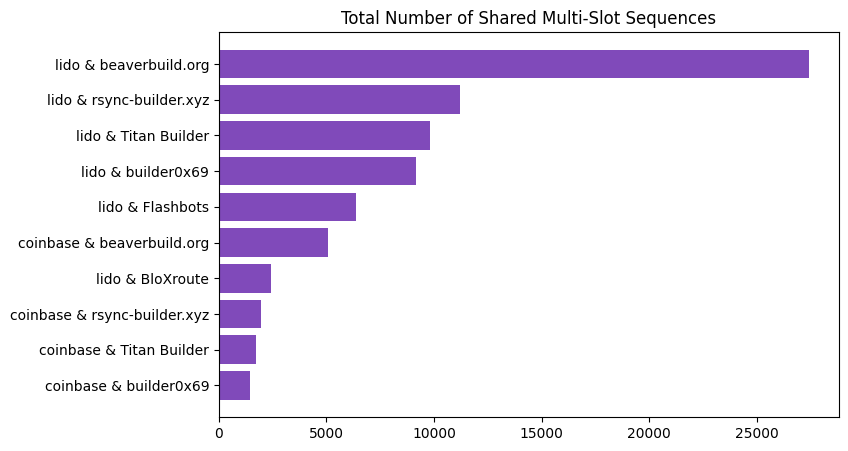

In [ ]:
# [Optional] Plotting Sum Of Multi-Slots with Same Builder & Validator

pivot_table_builder_validator['Label_Graphics'] = (
    pivot_table_builder_validator.index.get_level_values('validator').str[:20] + ' & ' +
    pivot_table_builder_validator.index.get_level_values('builder').str[:20]
)

pivot_table_builder_validator_top_10 = pivot_table_builder_validator.sort_values(by='Total_multi', ascending=False).head(10)
#print(pivot_table_builder_validator_top_10)

plt.figure(figsize=(8, 5))
plt.barh(pivot_table_builder_validator_top_10['Label_Graphics'], pivot_table_builder_validator_top_10['Total_multi'], color='#804aba')
plt.title('Total Number of Shared Multi-Slot Sequences')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.title('Total Number of Shared Multi-Slot Sequences')
plt.savefig(base_directory + 'Graphics/Total Number of Shared Multi-Slot Sequences.png')
plt.show()

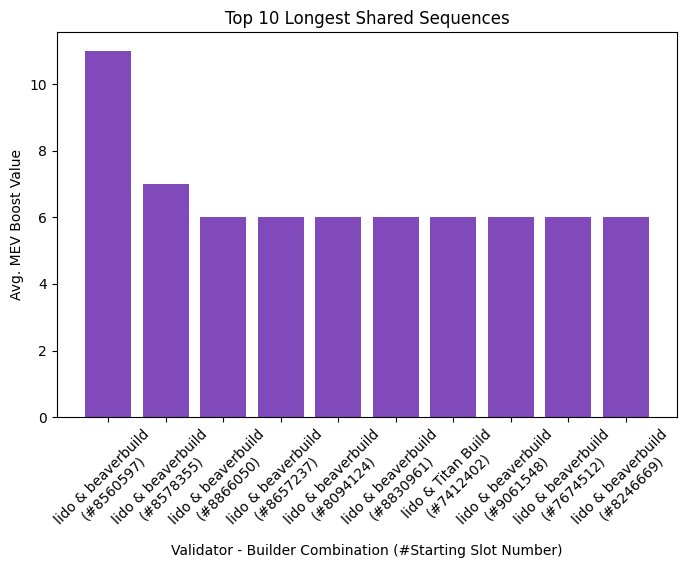

In [ ]:
## [Optional] Histogram of longest shared sequences

# Combine validator and Builder for labels
consecutive_analysis_builder_validator['Label_Graphics'] = (
    consecutive_analysis_builder_validator['validator'].str[:12] + ' & ' +
    consecutive_analysis_builder_validator['builder'].str[:11] + '\n(#' +
    consecutive_analysis_builder_validator['slot_numbers'].apply(lambda x: str(x[0])) + ')'
  )
# Ensure the DataFrame is sorted by Value if you only want the top 10 highest values
consecutive_analysis_builder_validator_sorted = consecutive_analysis_builder_validator.sort_values(by='consecutive_slots', ascending=False).head(10)

# Plotting the histogram
plt.figure(figsize=(8, 5))
plt.bar(consecutive_analysis_builder_validator_sorted['Label_Graphics'], consecutive_analysis_builder_validator_sorted['consecutive_slots'], color='#804aba')
plt.xlabel('Validator - Builder Combination (#Starting Slot Number)')
plt.ylabel('Avg. MEV Boost Value')
plt.title('Top 10 Longest Shared Sequences')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.title('Top 10 Longest Shared Sequences')
plt.savefig(base_directory + 'Graphics/Top 10 Longest Shared Sequences.png')
plt.show()

We observe that Lido and Beaverbuild have the most shared multi-slot sequences (around 26k). This is expected and it generally shows the trend that the market participants with the highest market shares, have the most shared sequences.

The longest observed shared sequence is 11 slots from Lido & BeaverBuild and happend on March 4th, 2024 starting in slot #8,560,597 (can be confirmed on [Beaconchai.in](https://beaconcha.in/slot/8560597)). Based on randomness, the length of such a sequence is unlikely. There could be several reasons for this, for example it might be caused by temporary tests in different bidding strategies.

It is to note that we treat staking pool providers like Lido as one entity, even though they have a decentralized set of operators. This is done, as in essence it is covered by the same governance.

Based on a first exploratory analysis no collusive or atypical patterns can be seen in the data. However, we more in-depth analysis is needed to better understand the data.

### 2.4.4. Monte Carlo Simulation of Multi-Slot Sequences

Based on the market shares of the builders a simple Monte Carlo simulation is done to derive at expected multi-slot sequences. For each slot in the observed time period based on the market shares a builder is randomly drawn to be winning the auction. After the ca. 4 million slots are simulated it is counted for each builder how many multi-slot sequences they received of different length. This is done 10 times and averaged to avoid outliers (can be adjusted by changing the *num_simulations* variable).

In [88]:
## [Data Transformation] Monte Carlo Simulation on number of concurrent slots based on Market Shares (can be time-intensive)
# Can be run either for total time span or monthly (might be adjusted for shorter time periods as well,
# then only builder market shares cell above has to be set to different time spans)


# Define the time span to use: 'total', 'monthly', or 'daily'
TIME_SPAN = 'daily'  # Set to 'total', 'monthly', or 'daily'
NUM_SIMULATIONS = 100  # Number of simulations

def count_sequences(simulated_slots, builders):
    # Initialize results table for this simulation
    mc_results = pd.DataFrame(0, index=builders, columns=[str(i) for i in range(1, 26)])

    # Dictionary to hold sequences for each builder
    sequences = defaultdict(lambda: defaultdict(int))

    # Count sequences for each builder
    current_builder = simulated_slots[0]
    current_sequence = 1

    for i in range(1, len(simulated_slots)):
        if simulated_slots[i] == current_builder:
            current_sequence += 1
        else:
            if current_sequence >= 1:
                # Limit sequence length to 25 as longest observed sequence in data
                if current_sequence > 25:
                    current_sequence = 25
                sequences[current_builder][current_sequence] += 1
            current_builder = simulated_slots[i]
            current_sequence = 1

    # Add the last sequence
    if current_sequence >= 1:
        if current_sequence > 25:
            current_sequence = 25
        sequences[current_builder][current_sequence] += 1

    # Update the DataFrame in one go
    for builder, seq_counts in sequences.items():
        for seq_length, count in seq_counts.items():
            mc_results.at[builder, str(seq_length)] += count

    return mc_results

def run_simulation_all_or_periodic(TIME_SPAN, NUM_SIMULATIONS):
    start_time = datetime.now()

    if TIME_SPAN in ['monthly', 'daily']:
        cumulative_results_all_runs = []
        for _ in range(NUM_SIMULATIONS):
            all_simulated_slots = []
            if TIME_SPAN == 'monthly':
                group_period = 'year_month'
                market_share_df = monthly_market_share
            elif TIME_SPAN == 'daily':
                group_period = 'year_day'
                market_share_df = daily_market_share

            for period, market_share_df_period in market_share_df.groupby(group_period):
                builders = market_share_df_period['Builder'].to_numpy()
                market_shares = market_share_df_period['Market Share (%)'].to_numpy()
                probabilities = market_shares / np.sum(market_shares)
                draws = market_share_df_period['Count'].sum()
                # Simulate the draws
                simulated_slots = np.random.choice(builders, size=draws, p=probabilities)
                all_simulated_slots.extend(simulated_slots)

            # Combine all simulated slots this run & count sequences
            combined_slots_this_run = np.array(all_simulated_slots)
            cumulative_results_all_runs.append(count_sequences(combined_slots_this_run, market_share_df['Builder'].unique()))

        # Average the results from all runs
        cumulative_results = pd.concat(cumulative_results_all_runs).groupby(level=0).mean()

    else:
        builders = total_market_share['Builder'].to_numpy()
        market_shares = total_market_share['Market Share (%)'].to_numpy()
        probabilities = market_shares / np.sum(market_shares)
        draws = sum(consecutive_slots_table.columns.astype(int) * consecutive_slots_table.sum())

        all_simulated_slots = []
        for _ in range(NUM_SIMULATIONS):
            simulated_slots = np.random.choice(builders, size=draws, p=probabilities)
            all_simulated_slots.extend(simulated_slots)

        # Combine all simulated slots (logic could be adjusted to above)
        combined_builders = np.array(all_simulated_slots)
        cumulative_results = count_sequences(combined_builders, total_market_share['Builder'])
        cumulative_results = cumulative_results / NUM_SIMULATIONS

    end_time = datetime.now()

    ## Print results, can be commented in
    # pd.set_option('display.float_format', '{:.2f}'.format)
    # print(cumulative_results)
    # pd.reset_option('display.float_format')

    # Sanity check
    total_wins_in_simulation = sum(int(col) * cumulative_results[col].sum() for col in cumulative_results.columns)
    print(f"Total wins from sequences in simulation: {int(total_wins_in_simulation)}")
    if TIME_SPAN in ['monthly', 'daily']:
        print(f"Total number of draws (should (close to) be equal to total wins from streaks): {len(all_simulated_slots)}")
    else:
        print(f"Total number of draws (should be equal to total wins from streaks): {len(all_simulated_slots)/NUM_SIMULATIONS}")
    print(f"Simulation time: {end_time - start_time}")

    return cumulative_results

# Run the simulation
mc_results = run_simulation_all_or_periodic(TIME_SPAN, NUM_SIMULATIONS)

# print(mc_results.head())

Total wins from sequences in simulation: 3792175
Total number of draws (should (close to) be equal to total wins from streaks): 3792189
Simulation time: 0:07:51.213650


In [89]:
## [Optional] Export Results of Monte Carlo

current_time = datetime.now()
time_str = current_time.strftime('%Y-%m-%d_%H-%M')

base_file_path_mc = base_directory + 'MC/Monte Carlo'
file_path = f"{base_file_path_mc} - {time_str} - {TIME_SPAN} -  {NUM_SIMULATIONS}.csv"
mc_results.to_csv(file_path)

### 2.4.5. Comparison between observed (Data) and expected (Monte Carlo) Occurences of Multi-Slot Sequences

In [90]:
## [MAIN-ANALYSIS] Difference between observed and expected occurence (run other elements before)

expected_occurence = mc_results.astype(float)
observed_occurence = consecutive_slots_table_reduced.astype(int)


expected_occurence.columns = expected_occurence.columns.astype(str)
observed_occurence.columns = observed_occurence.columns.astype(str)
expected_occurence = expected_occurence.reindex_like(observed_occurence)

# Sanity Check - Calculate weighted sums (number of occurrences multiplied by the slot number they represent)
expected_slots_sum = (expected_occurence * expected_occurence.columns.astype(int)).sum().sum()
observed_slots_sum = (observed_occurence * observed_occurence.columns.astype(int)).sum().sum()

print("Check if Expected and Observed Dataset have about the same number of slots:")
print(f"Number of Occurrences of Slots in Monte Carlo Simulation: {int(expected_slots_sum)}")
print(f"Observed Occurrences # of Slots in Dataset: {observed_slots_sum}")

pd.set_option('display.max_columns', None)  # Adjust to show all columns

## Print output (can be commented in)
#print("Expected Occurences")
#print(expected_occurence)
#print("Observed Occurences")
#print(observed_occurence)

# Calculating the Difference
difference_df = (observed_occurence-expected_occurence)

## Print output (can be commented in)
#print("Differences (Observed - Expected):")
#print(difference_df)

# Replace 0 in expected_occurence conditionally based on observed_occurence to avoid infinite results at relative deviation comparison
expected_occurence = pd.DataFrame(
    np.where((expected_occurence == 0) & (observed_occurence == 0),
             np.nan,  # Insert NaN where both expected and observed are zero
             np.where(expected_occurence == 0,
                      0.1,  # Insert 0.1 where expected is zero but observed is not
                      expected_occurence)),  # Keep original value otherwise
    index=expected_occurence.index,
    columns=expected_occurence.columns
)

# Calculation of relative deviation
relative_deviation = ((observed_occurence - expected_occurence) / expected_occurence) * 100

## Print output (can be commented in)
# print("Relative Deviation (%):")
# print(relative_deviation)

pd.set_option('display.max_columns', None)  # Adjust to show all columns
pd.reset_option('display.max_columns')

Check if Expected and Observed Dataset have about the same number of slots:
Number of Occurrences of Slots in Monte Carlo Simulation: 3792175
Observed Occurrences # of Slots in Dataset: 3792189


#### Histogram of observed vs. expected multi-slot Sequences

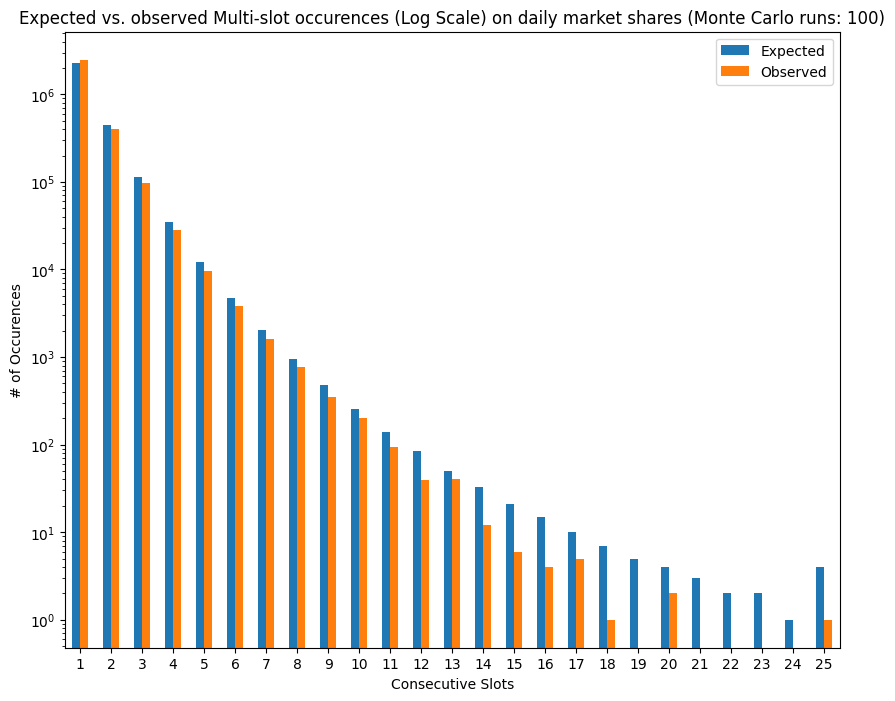

In [91]:
# [Visualization] - Histogram total observed vs. expected consecutive slots

occurences_combined = pd.concat([expected_occurence.sum().round(), observed_occurence.sum()], axis=1)
occurences_combined.columns = ['Expected', 'Observed']

occurences_combined.plot(kind='bar', figsize=(10, 8), logy=True)
plot_title = f"Expected vs. observed Multi-slot occurences (Log Scale) on {TIME_SPAN} market shares (Monte Carlo runs: {NUM_SIMULATIONS})"
plt.title(plot_title)
plt.xlabel('Consecutive Slots')
plt.ylabel('# of Occurences')
plt.xticks(rotation=0)
plt.savefig(f"{base_directory}/Graphics/{plot_title}.png")
plt.show()

It can be observed that there are significantly more multi-slot/consecutive slot sequences than expected and a lot less single slot sequences (please note the log scale). Based on the Monte-Carlo simulation more than 11 consecutive slots given the roughly 4 million simulated slots seems unlikely. However, in the data many occurences of longer sequences can be found with the longest sequence being 25 slots, which occured on 25th of June 2023 by beaverbuild.org (https://beaconcha.in/slot/6737452).

#### Average expected vs. observed consecutive Slot Length per Builder


To understand this trend in a more fine-grained manner the average consecutive slot length per builder is calculated for the expected and observed data set and compared. Note, that this is different for each builder, as the market share (probability) plays into the chances for multi-sequences.

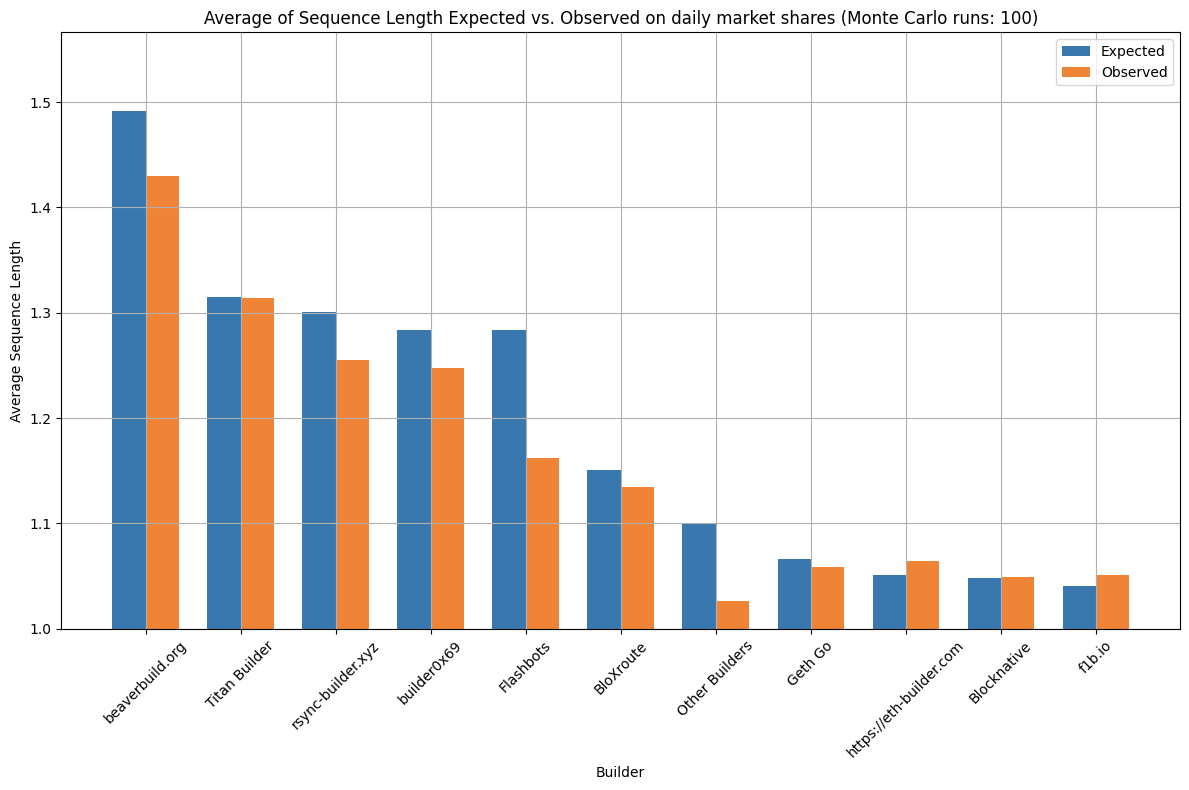

In [92]:
## [Analysis & Visualization] Average expected and observed Consecutive Slot Length per Builder

# Multiply each cell by its column name (consecutive slots)
expected_occurence = expected_occurence.fillna(0).astype(int)
observed_occurence.columns = pd.to_numeric(observed_occurence.columns)
expected_occurence.columns = pd.to_numeric(expected_occurence.columns)
weighted_oo = observed_occurence.mul(observed_occurence.columns, axis=1)
weighted_eo = expected_occurence.mul(expected_occurence.columns, axis=1)

# Sum the results for each row to get the total weighted count
weighted_sums_oo = weighted_oo.sum(axis=1)
weighted_sums_eo = weighted_eo.sum(axis=1)

# Sum the unweighted counts for each row
total_counts_oo = observed_occurence.sum(axis=1)
total_counts_eo = expected_occurence.sum(axis=1)

# Calculate the weighted average for each row
weighted_averages_oo = weighted_sums_oo / total_counts_oo
weighted_averages_eo = weighted_sums_eo / total_counts_eo

# Sort the observed weighted averages in descending order
sorted_indices = weighted_averages_eo.sort_values(ascending=False).index

# Reorder both observed and expected weighted averages according to the sorted indices
sorted_weighted_averages_oo = weighted_averages_oo.reindex(sorted_indices)
sorted_weighted_averages_eo = weighted_averages_eo.reindex(sorted_indices)


## Print Output / can be commented in
#print("Observed Weighted Averages:")
#print(weighted_averages_oo)
#print("\nExpected Weighted Averages:")
#print(weighted_averages_eo)

# Visualization
# Bar chart parameters
bar_width = 0.35  # Width of the bars
index = np.arange(len(sorted_weighted_averages_oo))  # Index for the builder

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(index - bar_width/2, sorted_weighted_averages_eo, bar_width, label='Expected', color='#3978af')
bars2 = ax.bar(index + bar_width/2, sorted_weighted_averages_oo, bar_width, label='Observed', color='#f08436')

# Adding labels and titles
ax.set_xlabel('Builder')
ax.set_ylabel('Average Sequence Length')
plot_title = f"Average of Sequence Length Expected vs. Observed on {TIME_SPAN} market shares (Monte Carlo runs: {NUM_SIMULATIONS})"
ax.set_title(plot_title)
ax.set_xticks(index)
ax.set_xticklabels(sorted_weighted_averages_oo.index)
ax.legend()

ax.set_ylim(bottom=1)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{base_directory}/Graphics/{plot_title}.png")
plt.show()

It can be observed that all of the top 10 builders, except the flashbots builder, have more/longer multi-slot sequences than expected. For long tail builders (defined as non-top 10 in this setting), it is less. A few builders stand out, such as beaverbuild.org, builder0x69, Titan Builder and BloXroute. We assume that at least for some of the builders this can be attributed to changing market shares over the course of the observation period. As shown in a recent paper by [Yang et al., 2024](https://https://arxiv.org/pdf/2405.01329) the market shares have shifted significantly over the observation period. This is underlined by the fact that the effect is less prevalent when running the analyses on only specific time periods in the data (to do this, in earlier cells comment in the respective code). Filtering this effects out more structually and analyzing further effects remains the scope for future research.

In the next step, we focused on comparing the expected vs. observed occurences of specific multi-slot sequences per builder. Therefore, several visual representations are created to get an insight into it.

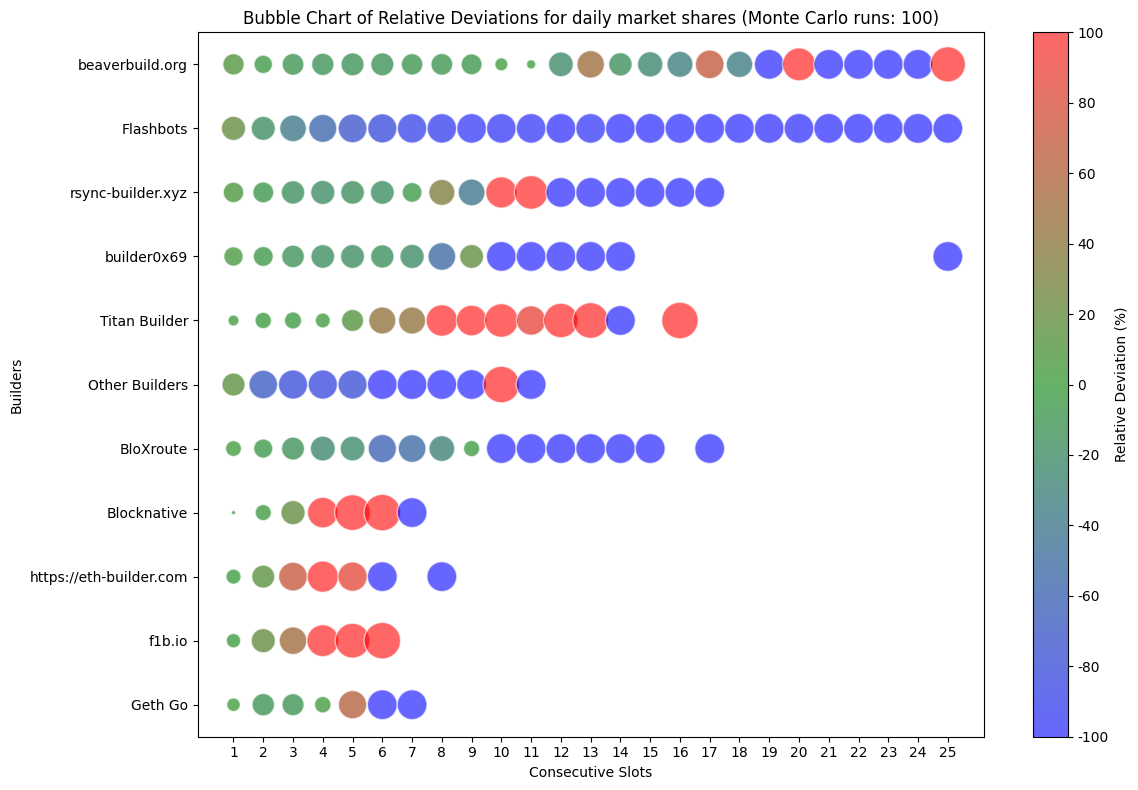

In [93]:
## [Data Visualization] Relative Deviation as a Bubble Chart


# Reverse the index for plotting (builders from bottom to top)
relative_deviation = relative_deviation.iloc[::-1] # might be adjusted as this might needs to be run twice if run repetitively

# Prepare grid coordinates for plotting, taking into account the reversed DataFrame
x, y = np.meshgrid(np.arange(len(relative_deviation.columns)), np.arange(len(relative_deviation.index)))

# Flatten the arrays for easy plotting
x = x.flatten()
y = y.flatten()
size = relative_deviation.values.flatten()  # Flatten the size data

# Reduce all size values to a reduced range [-1000, 1000] for better visbility
capped_size = np.clip(size, -1000, 1000)

# Logarithmic scaling for sizes; adding 1 to ensure no log(0) issues
scaled_sizes = np.log(np.abs(capped_size) + 1) * 100

# Define a custom color map: blue (negative), green (zero deviation), red (positive)
colors = ["blue", "green", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)
norm = mcolors.Normalize(vmin=-100, vmax=100)  # Set color normalization

# Alternative coloring
#cmap = plt.cm.RdBu  # Diverging colormap 'RdBu'
#norm = mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)  # Ensures zero is in the center


# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
bubble = ax.scatter(x, y, s=scaled_sizes, c=capped_size, cmap=cmap, norm=norm, alpha=0.6, edgecolors="w", linewidth=1)

# Color bar setup
cbar = fig.colorbar(bubble)
cbar.set_label('Relative Deviation (%)')
tick_values = np.linspace(-100, 100, num=11)  # Generates 7 evenly spaced ticks
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f"{v:.0f}" for v in tick_values])

# Set ticks and labels
ax.set_xticks(np.arange(len(relative_deviation.columns)))
ax.set_yticks(np.arange(len(relative_deviation.index)))
ax.set_xticklabels(relative_deviation.columns)
ax.set_yticklabels(relative_deviation.index)
ax.set_xlabel('Consecutive Slots')
ax.set_ylabel('Builders')
plot_title = f"Bubble Chart of Relative Deviations for {TIME_SPAN} market shares (Monte Carlo runs: {NUM_SIMULATIONS})"
ax.set_title(plot_title)
plt.tight_layout()
plt.savefig(f"{base_directory}/Graphics/{plot_title}.png")
plt.show()

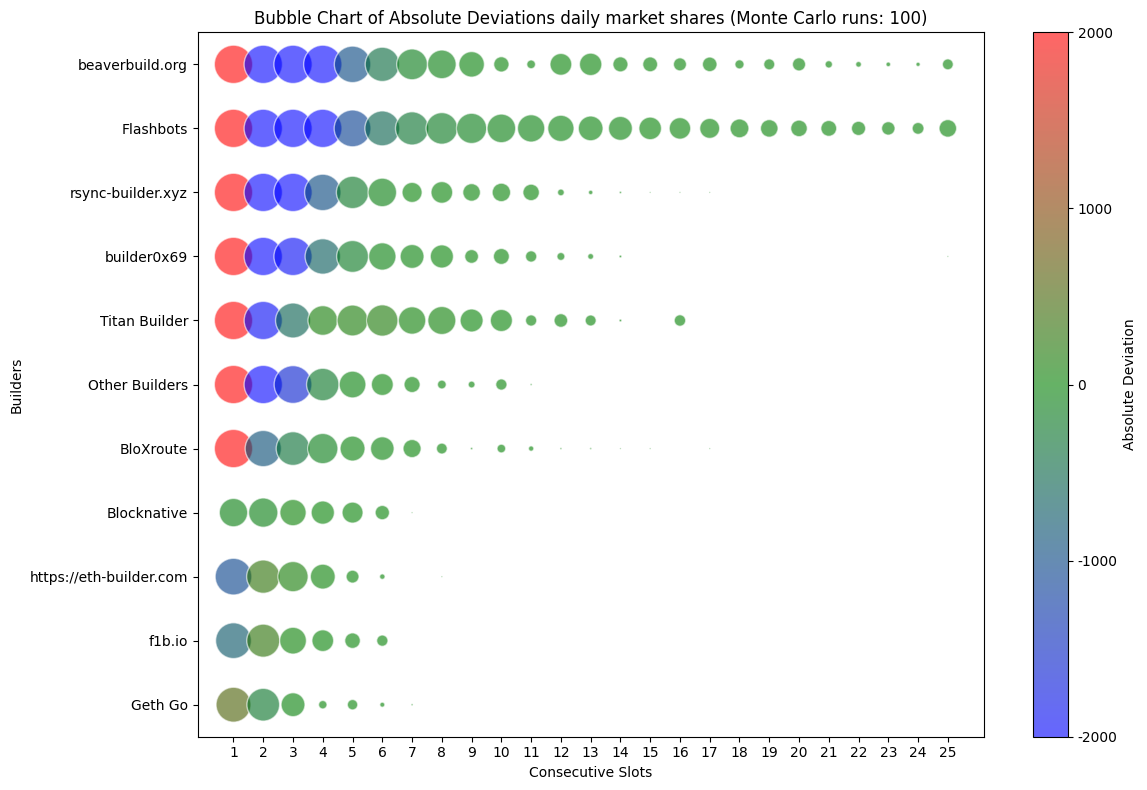

In [94]:
## [Data Visualization] Bubble Chart of Absolute Deviations

# Reverse the index for plotting (builders from top to bottom)
difference_df_inv = difference_df.iloc[::-1]
builders = difference_df_inv.index

# Prepare grid coordinates for plotting, considering the reversed DataFrame
x, y = np.meshgrid(np.arange(len(difference_df_inv.columns)), np.arange(len(builders)))

# Flatten the arrays for easy plotting
x = x.flatten()
y = y.flatten()

# Cap and flatten the size data
size = difference_df_inv.values.flatten()  # Flatten the size data first
capped_sizes = np.clip(size, a_min=-2000, a_max=2000)  # Cap values for better visibility

# Apply a logarithmic transformation to scale the sizes, adding 1 to avoid log(0)
scaled_sizes = np.log(np.abs(capped_sizes) + 1) * 100  # Scale factor for visibility

# Define a custom color map with blue, grey, and red
colors = ["blue", "green", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip([0.0, 0.5, 1.0], colors)))
norm = mcolors.TwoSlopeNorm(vmin=-2000, vcenter=0, vmax=2000)

# Alternative coloring
#cmap = plt.cm.RdBu  # Diverging colormap 'RdBu'
#norm = mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)  # Ensures zero is in the center


# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
bubble = ax.scatter(x, y, s=scaled_sizes, c=capped_sizes, cmap=cmap, norm=norm, alpha=0.6, edgecolors="w", linewidth=1)

# Add a color bar
cbar = fig.colorbar(bubble)
cbar.set_label('Absolute Deviation')
cbar.set_ticks([-2000, -1000, 0, 1000, 2000])
cbar.set_ticklabels(['-2000', '-1000', '0', '1000', '2000'])

# Set ticks and labels
ax.set_xticks(np.arange(len(difference_df_inv.columns)))
ax.set_yticks(np.arange(len(builders)))
ax.set_xticklabels(difference_df_inv.columns)
ax.set_yticklabels(builders)
ax.set_xlabel('Consecutive Slots')
ax.set_ylabel('Builders')
plot_title = f"Bubble Chart of Absolute Deviations {TIME_SPAN} market shares (Monte Carlo runs: {NUM_SIMULATIONS})"
ax.set_title(plot_title)
plt.tight_layout()
plt.savefig(f"{base_directory}/Graphics/{plot_title}.png")
plt.show()

It can be observed in the relative as well as in the absolute deviation that for all top 10 builders there are less single slot sequences as expected with the exception of Flashbots. For multi-slot sequences with two or more slots all top 10 builders have more than expected with the exception of beaverbuild.org.

## 2.5. MEV Boost Payment Analysis for Multi-Slot Sequences

So far, only the frequency of multi-slot sequences has been investigated. In the next step, it will also be analyzed, if the payments for multi-slot sequences are higher than for single slot sequences. The guiding question is: Are builder willing to pay more for creating the blocks for multi-slots in a row?

It is important to know, that in the current PBS design with MEV boost block building rights are auctioned off just-in-time (JIT), so builders can never know in advance if they control more than one slot and hence cannot run multi-slot strategies that need a guarantee of securing subsequent slots.

### 2.5.1. Average Payments for longer Sequences

In a first step, the average payments for slots are analyzed based on the average MEV boost payment per slot in the sequence. For better visibility the number of slots can be limited to 10. Further, to avoid for potential errors in the data and better visibility, outliers are filtered out.

<Figure size 1200x600 with 0 Axes>

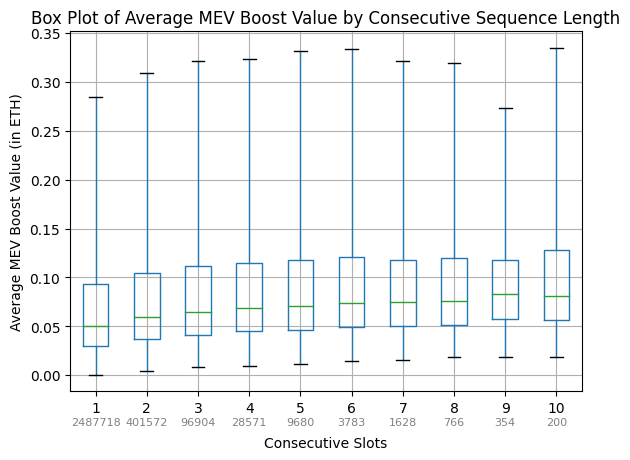

In [84]:
# [Analysis] - Payment for consecutive slots

from matplotlib.ticker import ScalarFormatter


ca_df = consecutive_analysis.copy()

FILTER_OUT_OUTLIERS = False

lower_bound = ca_df['avg_mevboost_value'].quantile(0.05)
upper_bound = ca_df['avg_mevboost_value'].quantile(0.95)

# Filter out outliers (select if outliers shall be filtered)
if FILTER_OUT_OUTLIERS:
  filtered_ca_df = ca_df[(ca_df['avg_mevboost_value'] >= lower_bound) & (ca_df['avg_mevboost_value'] <= upper_bound)]
else:
  filtered_ca_df = ca_df

# Optional: filter for the first 10 slots
filtered_ca_df = filtered_ca_df[filtered_ca_df['consecutive_slots'] <= 10]

# Convert to ETH
filtered_ca_df.loc[:, 'avg_mevboost_value'] = filtered_ca_df['avg_mevboost_value'] / 10**18

# Create a box plot
plt.figure(figsize=(12, 6))
boxplot = filtered_ca_df.boxplot(column='avg_mevboost_value', by='consecutive_slots', grid=True, whis=3, showfliers=False)
plt.title('Box Plot of Average MEV Boost Value by Consecutive Sequence Length')
plt.suptitle('')
plt.xlabel('Consecutive Slots', labelpad=15)
plt.ylabel('Average MEV Boost Value (in ETH)')
if FILTER_OUT_OUTLIERS:
  plt.figtext(0.1, 0.01, "Note: Outliers have been filtered based on the th and 95th percentiles.",
              ha="left", fontsize=6, color="black")
plt.yscale('linear')
# Annotate sample sizes below the x-axis
slot_counts_boxplot = filtered_ca_df['consecutive_slots'].value_counts().sort_index()
for i, slot in enumerate(slot_counts_boxplot.index):
        plt.annotate(str(slot_counts_boxplot[slot]), (i+1, min(filtered_ca_df['avg_mevboost_value']) * 0.95), textcoords="offset points", xytext=(0,-30), ha='center', va='top', fontsize=8, color='grey')
plt.savefig(f"{base_directory}/Graphics/Box Plot of Average MEV Boost Value by Consecutive Sequence Length.png")
plt.show()

In accordance with previous work of [Jensen et al., 2023](https://arxiv.org/pdf/2303.04430) payments for longer consecutive sequences rise. Note that the gray numbers provide the sample size for each slot length. The sample size seems large enough to not be driven by individual values. So, it can be observed that in this data sample, the longer the sequence, almost linearly the average payment per slot rises.

This indicates that there is value in longer slot sequences.

To further understand if there are builder specific patterns the data is plotted for each builder separately in the next step.

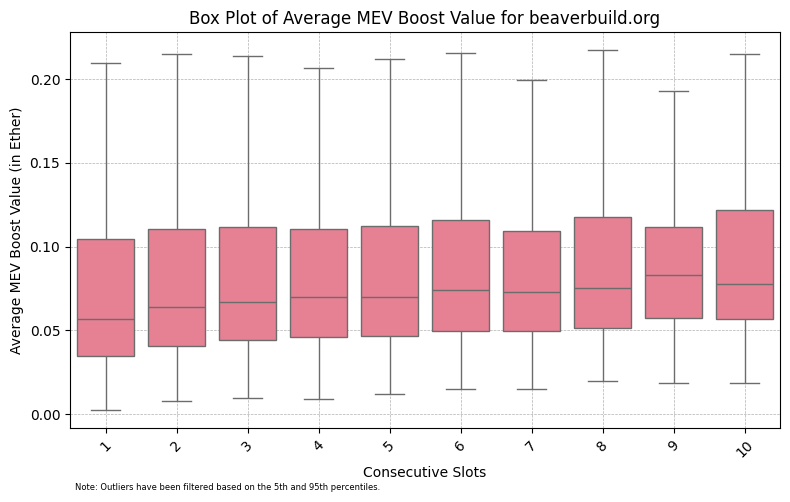

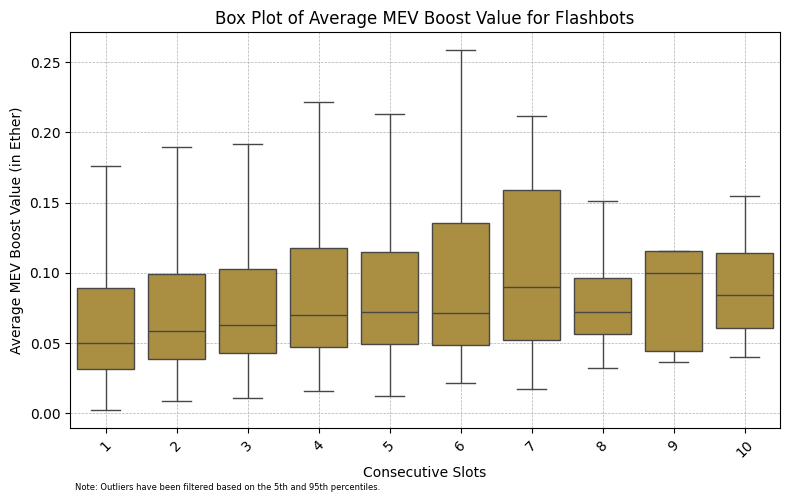

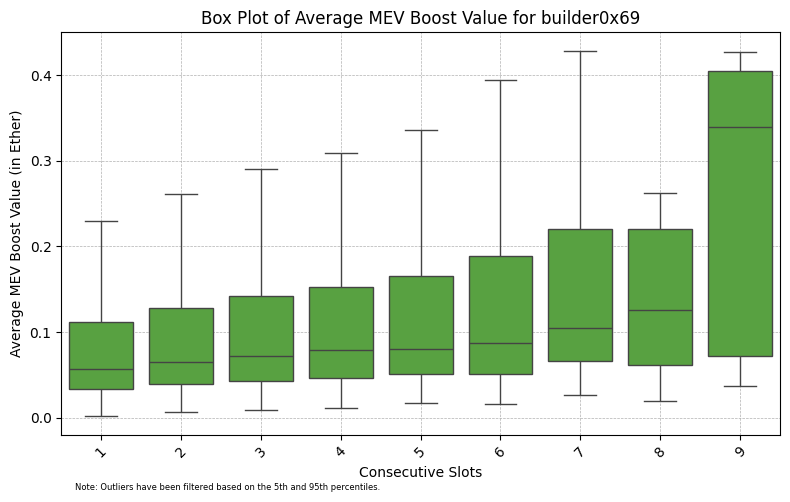

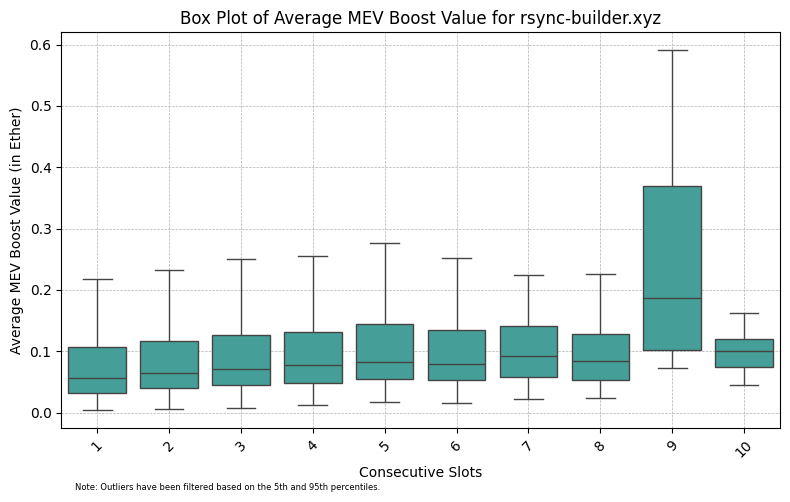

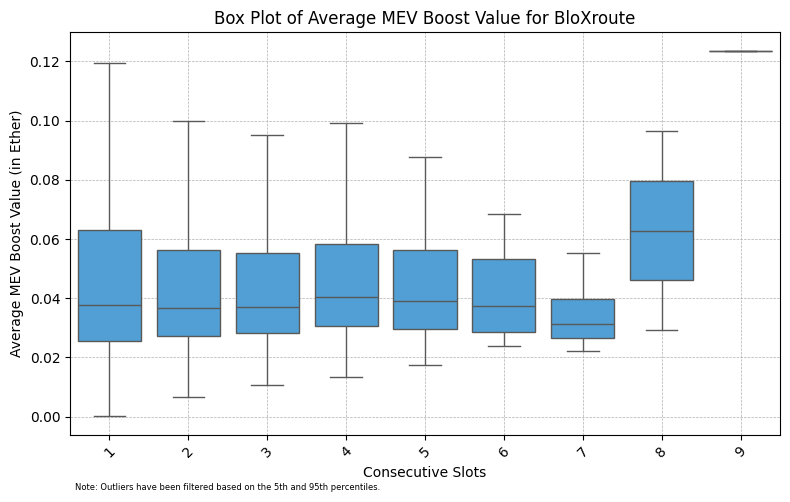

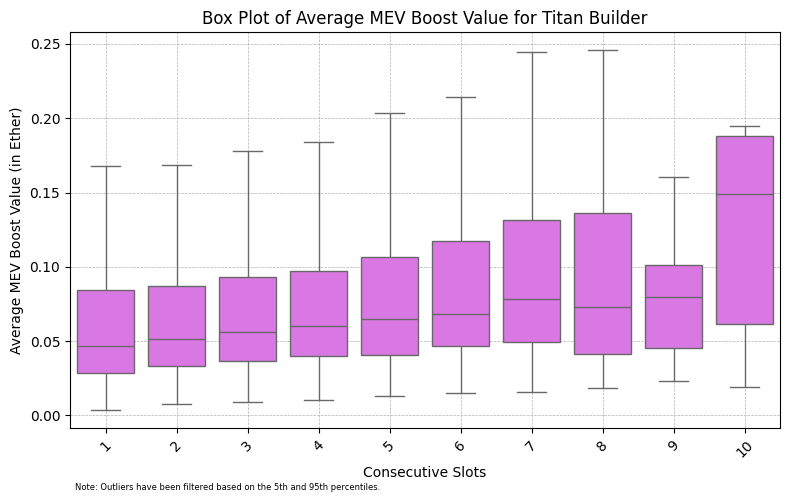

In [85]:
# [Visualization] Payments per Builder per Sequence Length

# Specify the builders you are interested in
selected_builders = ['beaverbuild.org', 'Flashbots', 'builder0x69', 'rsync-builder.xyz'#,'Other Builders'
                     ,'BloXroute', 'Titan Builder'
                    #, 'Blocknative', 'https://eth-builder.com', 'Geth Go', 'f1b.io '
                    ]  # Adjust the list as necessary

# Filter the DataFrame to include only the selected builders
selected_builders_df = filtered_ca_df[filtered_ca_df['builder'].isin(selected_builders)]

colors = sns.color_palette("husl", len(selected_builders))

# Loop through each builder and create a separate plot with a different color
for i, builder in enumerate(selected_builders):
    builder_df = selected_builders_df[selected_builders_df['builder'] == builder]

    # Create the plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='consecutive_slots', y='avg_mevboost_value', data=builder_df, color=colors[i], showfliers=False)
    plt.title(f'Box Plot of Average MEV Boost Value for {builder}')
    plt.xlabel('Consecutive Slots')
    plt.ylabel('Average MEV Boost Value (in Ether)')
    plt.xticks(rotation=45)
    plt.yscale('linear')

    # Comment in if yscale set to log (useful when showing fliers)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    #plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    #plt.gca().yaxis.set_minor_formatter(ScalarFormatter())


    plt.figtext(0.1, 0.01, "Note: Outliers have been filtered based on the 5th and 95th percentiles.",
            ha="left", fontsize=6, color="black")
    plt.tight_layout()
    plt.savefig(f"{base_directory}/Graphics/Box Plot of Average MEV Boost Value for {builder}.png")
    plt.show()

It can be observed that the pattern of increasing average payments for longer sequences persists among most builders. Noteably builder0x69 shows a higher upper quartile range for longer sequences. BloXroute on the contrary shows very low and non-increasing average payments for longer sequences. It is to note that especially for builders with a lower marketshare only few instances of longer sequences exist that might tilt the data and observations have to be considered with care.

### 2.5.2. Average Payments per Slot position in longer Sequences

<Figure size 1200x600 with 0 Axes>

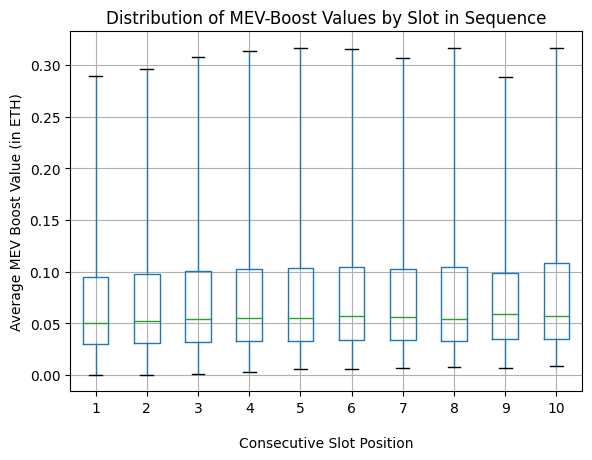

In [ ]:
# [Analysis & Visualization] MEV Payment on average per slot position
# In this analysis MEV payments are ordered via the position in a consecutive sequence and then the average is taken

FILTER_OUT_OUTLIERS = False

# Copy again consecutive analysis as now all_mevboost_values are used not avg_mevboost_value
ca_df_2 = consecutive_analysis.copy()

# Function to filter outliers to avoid outlier bias. Needs to be done for each value in the list
def filter_outliers_global(value_list, lower_bound, upper_bound):
    return [value for value in value_list if lower_bound <= value <= upper_bound]

# Flatten MEV Boost Values to identify outliers on global level
all_mev_values = [item for sublist in ca_df_2['all_mevboost_values'] for item in sublist if not np.isnan(item)]
lower_bound_single_values = np.quantile(all_mev_values, 0)
upper_bound_single_values = np.quantile(all_mev_values, 1)

# Applying the function to filter out the outliers
if FILTER_OUT_OUTLIERS:
  ca_df_2['filtered_mevboost_values'] = ca_df_2['all_mevboost_values'].apply(filter_outliers_global, args=(lower_bound_single_values, upper_bound_single_values))
else:
  ca_df_2['filtered_mevboost_values'] = ca_df_2['all_mevboost_values']

# Convert values from Wei to Ether
ca_df_2['filtered_mevboost_values'] = ca_df_2['filtered_mevboost_values'].apply(lambda x: [y / 10**18 for y in x])

# Prepare the data by splitting each slot position of as a separate column, ensuring only the first 10 values are used
expanded_df = pd.DataFrame(ca_df_2['filtered_mevboost_values'].tolist())
max_columns = min(10, expanded_df.shape[1])  # Limit columns to 10 or the maximum available if less than 10
expanded_df = expanded_df.iloc[:, :max_columns]
expanded_df.columns = [int(i+1) for i in range(max_columns)]
#expanded_df = expanded_df[sorted(expanded_df.columns, key=lambda x: int(x))]

# Convert the DataFrame from wide format to long format for easier plotting with seaborn
melted_df = expanded_df.melt(var_name='Consecutive Slot', value_name='MEV-Boost Value')

# Create a box plot using pandas .boxplot method
plt.figure(figsize=(12, 6))
boxplot = melted_df.boxplot(column='MEV-Boost Value', by='Consecutive Slot', grid=True, whis=3, showfliers=False)

# Customizing the plot to match the first plot's style
plt.title('Distribution of MEV-Boost Values by Slot in Sequence')
plt.suptitle('')
plt.xlabel('Consecutive Slot Position', labelpad=15)
plt.ylabel('Average MEV Boost Value (in ETH)')
if FILTER_OUT_OUTLIERS:
  plt.figtext(0.1, 0.01, "Note: Outliers have been filtered based on the 5th and 95th percentiles.",
             ha="left", fontsize=6, color="black")
plt.yscale('linear')
plt.savefig(f"{base_directory}/Graphics/Distribution of MEV-Boost Values by Slot in Sequence.png")
plt.show()

Also in the payment per slot analysis a similar trend can be observed, however less prevalent. This suggests that there is value in longer sequences however builder are not willing to bid significantly more for longer consecutive sequences or the first slot after a longer sequence.

This indicates for us that, at least so far, multi-slot strategies are not applied systematically. In this case builders, would need to pay significantly higher values for later slots to ensure to capture the MEV opportunity prepared earlier.


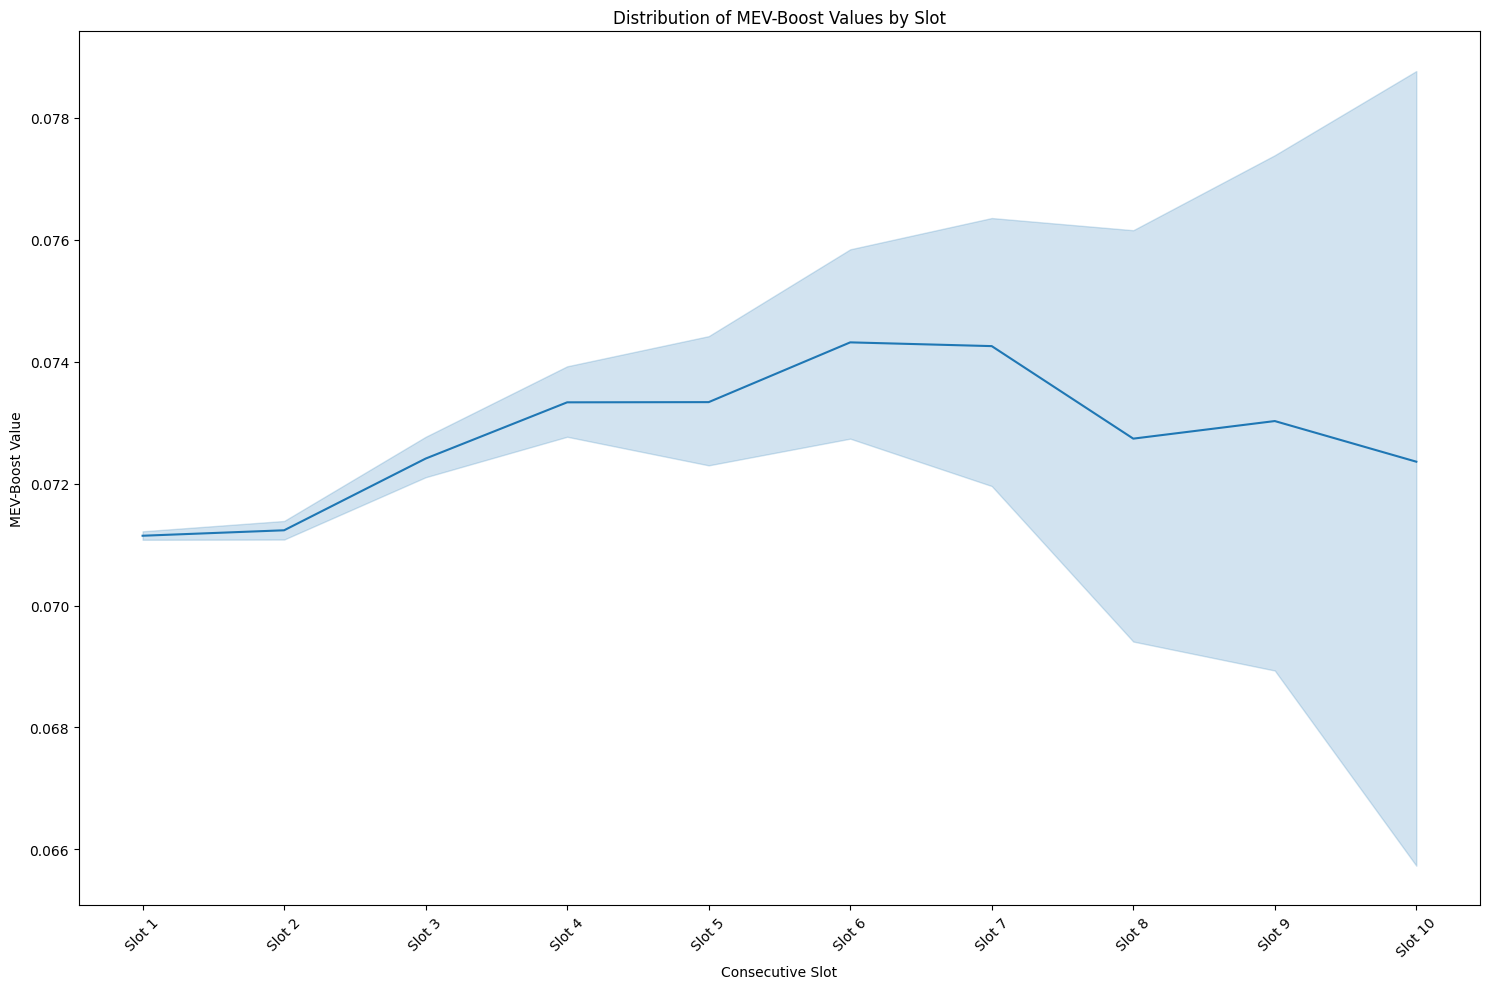

In [ ]:
## [Analysis] Validation of previous finding that average payment per slot position increases
# Requirement: previous analysis needs to be run that generates ca_df_2 dataframe

# Expanding the filtered and converted lists into a DataFrame
expanded_df = pd.DataFrame(ca_df_2['filtered_mevboost_values'].tolist())
expanded_df = expanded_df.iloc[:, :10]
expanded_df.columns = [f'Slot {i+1}' for i in range(expanded_df.shape[1])]

# Converting the DataFrame from wide format to long format for easier plotting with seaborn
melted_df = expanded_df.melt(var_name='Consecutive Slot', value_name='MEV-Boost Value')

# Ensure no zero or negative values for logarithmic scale (replacing 0 and negative values with a small number)
melted_df['MEV-Boost Value'] = melted_df['MEV-Boost Value'].clip(lower=0.0000001)

# Plotting using seaborn
plt.figure(figsize=(15, 10))
sns.lineplot(x='Consecutive Slot', y='MEV-Boost Value', data=melted_df)
plt.xticks(rotation=45)  # Rotate position labels for better readability
plt.title('Distribution of MEV-Boost Values by Slot')
plt.yscale('linear')  # Apply logarithmic scale to the y-axis
plt.tight_layout()
plt.savefig(f"{base_directory}/Graphics/Distribution of MEV-Boost Values by Slot.png")
plt.show()


## 2.6. Analysis of High Volatility Periods

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Cramers V for Volatility & Builder
cramers_v_result = cramers_v(mev_boost_data_clean['high_vola_simple'], mev_boost_data_clean['builder'])
print("Cramer's V:", cramers_v_result)

Cramer's V: 0.06640402276492245


## 2.7. Playground for Sanity Checks and Further Analysis

In [ ]:
## [Sanity Check] Search for individual slots to cross-check with https://beaconcha.in/

# Filter for rows with X consecutive slots
num_consecutive_slots = 10
resp_builder = "Titan Builder"
rows_with_consecutive_slots = consecutive_analysis_filtered[
    (consecutive_analysis_filtered['consecutive_slots'] == num_consecutive_slots) &
    (consecutive_analysis_filtered['builder'] == resp_builder)
]

# Extract the slot numbers for these rows
slot_numbers_for_consecutive_slots = rows_with_consecutive_slots['slot_numbers']

slot_numbers_for_consecutive_slots.head()
#mev_boost_consecutive.head(5)



,slot_numbers
903876,"[7273631, 7273632, 7273633, 7273634, 7273635, ..."
926622,"[7391876, 7391877, 7391878, 7391879, 7391880, ..."
945156,"[7495985, 7495986, 7495987, 7495988, 7495989, ..."
1002792,"[7878418, 7878419, 7878420, 7878421, 7878422, ..."
1077514,"[8384447, 8384448, 8384449, 8384450, 8384451, ..."


## Limitations and Avenues for Future Research

### Limitations

The research is limited to publicly available MEV-Boost payments data. Potential private agreements are not reflected. Additionally the data was partially incomplete and in other parts contained duplicate information (see section 1 for the details). Further, it is assumed that the MEV-Boost payments accurately reflect the MEV value per block (efficient market hypothesis for MEV-Boost auctions). On the frequency analysis, the approach contains somewhat a chicken and egg-problem. The Monte Carlo simulation is run on market shares, while the market shares potentially derive from multi-slot sequences.

### Avenues for Future research
1.   Run analysis on Validator, not builder level as only validator can fully control consecutive slots
2.   Run the analysis on specific node operator level of staking pools (using the pubkey_mapping)
3.   Cross-check if changing market shares influence the trends
4.   Investigate if the trends have changed over time
5.   Run analysis only in high/low-volatility periods
6.   Use more time-series focused statistical models to search for trends (ARIMA, SARIMA, Prophets etc.)
